1) Project Topic: COVID-19 Model By: Bryan Arment

This problem is designed to pull demographic data about every county in the United States and combine it to the most recent estimates of COVID19 deaths by county in order to understand the affect the demographic information has on the expected COVID 19 deaths by county. This will be a regression model that is designed to predict COVID-19 deaths.

The reason I think this is an interesting topic is because COVID-19 is impacting the entire world right now and this analysis can be used to identify what jurisdictions are most at risk from  high severity of the virus allowing for better response planning.

To create this data I pulled in from 2 different datasets I found online from the US Census and another website USA facts. It was not part of a Kaggle type problem and I sourced it myself and determined the 'problem' to solve myself as well.



In [437]:
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices

2&3) DATA and DATA CLEANING:

These two sections of the project are mixed in the following sets of cells.

The first data set came from the US Census Bureau and can be found here:
https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html#par_textimage_1383669527  

This first dataset was huge as it was around 600k rows and 80 columns. Fortunetly I was able to pare this down pretty quickly.
The data was organized with county year and age information encoded in the rows with about 3000 counties, 10 years and 15 age groups encoded. This is why the dataset is so long. The columns represent total population for the row that fits into the demographic category at the top of each column. This data included sex and racial categories and every possible permutation of these which is how it ends up around 80 items. This gets pared down later. 

The first step in cleaning the data was filtering down to only the 2018 information as this was the best available demographic data by county I could find. 

The next issue I had was that this data set had the county and state FIPS codes seperated while the next dataset had them combined. I needed to concatenate them togeher and ensure that county fips always was 3 digits. To do so I cast both to string, added leading zeros to the county fips then concatenated to two fields together into the countyFIPS column.

The next issue with this dataset is that I still had 15 rows in each county that dealt with age ranges. I wanted to combine this into one average age for each county. This process is described in the coding comments below but in short it involved calculating an intermediate value based on the age range median time the population in that range followed by a groupby.sum to roll this into a total for the county which was then divided by the total population to come up with the average age of each county. I also reset index on the groupby object so that my new data set only has 1 line per county with the average age showwing. This also allowed me to sum up all of the demographic variables into their totals by county at the same time.

The second data set came from usafacts.org and can befound on this page:
https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/  

This data has a row for every county so about 3000 rows and has 105 columns which represent the county info and then running totals of COVID-19 deaths from 1/22/20 - 5/1/20. 

The rows also included a line for each state for unallocated deaths. This was causing NAN errors when merging with the first dataset so I dropped these values by filtering out all the 0 countyFIPS info before merging.

To combine the two data sets I merged the 5/1 column from the covid data set (the most updated total) with the demographic dataset based on the countyFIPS column I ensured was the same between each dataset.

I did a little more cleaning by combining some of the variables for example male_race and female_race were added together to make one race column for that data as I already had a male and female column. Additionally I only kept columns that related to age,gender and singular racial group. This eliminated a ton of the combinations the dataset had such as: "Not Hispanic, American Indian and Alaska Native alone or in combination female population" which i thought was getting way to granular and a lot of these columns didn't have much data in them regardless.

This takes us into our EDA Section below.



In [229]:
## read in the demograpic data file
demoData = pd.read_csv('cc-est2018-alldata.csv',encoding = 'latin-1')
##demo2018 = pd.read_csv('cc-est2018-alldata.csv')


In [230]:
## read in covid data
covidData = pd.read_csv('covid_deaths_usafacts.csv')

In [438]:
## the last column is the current total
covidData = covidData.rename(columns = ({'5/1/20':'TotalDeaths'}))
covidData = covidData[covidData.countyFIPS != 0]
covidData

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,TotalDeaths
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,1,2,2,2,2,3,3,3,3,3
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,3,4
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1009,Blount County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,56037,Sweetwater County,WY,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3191,56039,Teton County,WY,56,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3192,56041,Uinta County,WY,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3193,56043,Washakie County,WY,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
### only keep the 2018 data
demo2018 = demoData[demoData.YEAR == 11].copy()
demo2018.reset_index()

,index,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,190,50,1,1,Alabama,Autauga County,11,0,55601,26995,...,738,680,108,102,36,33,19,17,22,12
1,191,50,1,1,Alabama,Autauga County,11,1,3364,1728,...,79,66,12,5,4,7,3,4,5,3
2,192,50,1,1,Alabama,Autauga County,11,2,3423,1779,...,86,62,5,2,5,2,4,0,3,0
3,193,50,1,1,Alabama,Autauga County,11,3,3882,1977,...,74,67,12,9,3,4,2,2,3,1
4,194,50,1,1,Alabama,Autauga County,11,4,3755,1913,...,61,68,10,7,5,4,0,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59693,656673,50,56,45,Wyoming,Weston County,11,14,473,267,...,4,5,0,0,0,0,0,0,0,0
59694,656674,50,56,45,Wyoming,Weston County,11,15,336,168,...,2,1,0,0,0,0,2,0,0,0
59695,656675,50,56,45,Wyoming,Weston County,11,16,224,104,...,1,1,0,0,0,0,0,0,0,0
59696,656676,50,56,45,Wyoming,Weston County,11,17,196,88,...,1,1,0,0,1,0,0,0,0,0


In [233]:
##I eventually need to merge with another dataset based on the state & county fields. To do so I needed to add leading zeros to county
## this requires casting to string and filling so I will do so to both fields here
## will also concat into the countyFIPS 
demo2018['COUNTY'] = demo2018['COUNTY'].astype(str).str.zfill(3)
demo2018['STATE'] = demo2018['STATE'].astype(str)
demo2018['countyFIPS'] = demo2018['STATE']+ demo2018['COUNTY']
demo2018['countyFIPS'] = demo2018['countyFIPS'].astype('int64')

In [234]:
## next need to generate the average age of the county data 
## the coding in AGE GRP column is in 5 year increments for example grp 14 is 65-69
## i am going to take the median value of each group for purposes of calculating average age so grp 14 is treated as 67
## the final group is 85+ which I will treat as 87 to be conisiten with the 2 year offset in the other groups
## I am replacing these codes in place w/ a dictionary
ageMap = {1:2,2:7,3:12,4:17,5:22,6:27,7:32,8:37,9:42,10:47,11:52,12:57,13:62,14:67,15:72,16:77,17:82,18:87}
demo2018['AGEGRPMED'] = demo2018.AGEGRP.replace(ageMap)
demo2018['AVGAGEINT'] = demo2018.AGEGRPMED * demo2018.TOT_POP
demo2018

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,countyFIPS,AGEGRPMED,AVGAGEINT
190,50,1,001,Alabama,Autauga County,11,0,55601,26995,28606,...,102,36,33,19,17,22,12,1001,0,0
191,50,1,001,Alabama,Autauga County,11,1,3364,1728,1636,...,5,4,7,3,4,5,3,1001,2,6728
192,50,1,001,Alabama,Autauga County,11,2,3423,1779,1644,...,2,5,2,4,0,3,0,1001,7,23961
193,50,1,001,Alabama,Autauga County,11,3,3882,1977,1905,...,9,3,4,2,2,3,1,1001,12,46584
194,50,1,001,Alabama,Autauga County,11,4,3755,1913,1842,...,7,5,4,0,2,1,3,1001,17,63835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656673,50,56,045,Wyoming,Weston County,11,14,473,267,206,...,0,0,0,0,0,0,0,56045,67,31691
656674,50,56,045,Wyoming,Weston County,11,15,336,168,168,...,0,0,0,2,0,0,0,56045,72,24192
656675,50,56,045,Wyoming,Weston County,11,16,224,104,120,...,0,0,0,0,0,0,0,56045,77,17248
656676,50,56,045,Wyoming,Weston County,11,17,196,88,108,...,0,1,0,0,0,0,0,56045,82,16072


In [235]:
##removing the 0 rows from AGEGRP in preperation for a groupby countyFIPS that will allow me to calculate average age
demo2018 = demo2018[demo2018.AGEGRP != 0]
demo2018 = demo2018.groupby('countyFIPS').sum().reset_index()
demo2018['AVG_AGE'] = demo2018['AVGAGEINT']/demo2018['TOT_POP']
demo2018

,countyFIPS,SUMLEV,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,...,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,AGEGRPMED,AVGAGEINT,AVG_AGE
0,1001,900,198,171,55601,26995,28606,20859,21801,5153,...,102,36,33,19,17,22,12,801,2160177,38.851406
1,1003,900,198,171,218022,105657,112365,92471,97830,9400,...,253,259,192,69,57,56,34,801,9079854,41.646504
2,1005,900,198,171,24881,13133,11748,6410,5799,6370,...,49,62,31,1,0,11,8,801,1015312,40.806720
3,1007,900,198,171,22400,11921,10479,8762,8449,2954,...,16,7,14,1,0,18,3,801,893545,39.890402
4,1009,900,198,171,57840,28500,29340,27307,28149,507,...,59,58,65,16,17,32,23,801,2316435,40.049015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,900,198,171,43051,22152,20899,20834,19563,328,...,80,201,228,35,42,16,8,801,1562292,36.289331
3138,56039,900,198,171,23081,11909,11172,11357,10614,100,...,23,104,85,17,13,12,6,801,926472,40.140029
3139,56041,900,198,171,20299,10285,10014,9818,9538,78,...,22,88,110,5,13,8,3,801,744403,36.671905
3140,56043,900,198,171,7885,3988,3897,3778,3672,25,...,10,61,60,5,9,5,3,801,333460,42.290425


In [236]:
## need to pull the total death info in based on the county fips codes
## note that there were 1500 deaths that were unallocated/probable in NYC that got dropped on the merge as they arent assigned to a county
combinedData = demo2018.merge(covidData[['countyFIPS','TotalDeaths']])
combinedData['TotalDeaths'].sum()

62312

In [237]:
covidData[covidData.countyFIPS == 1]

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,TotalDeaths
1862,1,New York City Unallocated/Probable,NY,36,0,0,0,0,0,0,...,1934,1851,1702,1634,1555,1523,1561,1520,1491,1445


In [238]:
combinedData


,countyFIPS,SUMLEV,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,...,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,AGEGRPMED,AVGAGEINT,AVG_AGE,TotalDeaths
0,1001,900,198,171,55601,26995,28606,20859,21801,5153,...,36,33,19,17,22,12,801,2160177,38.851406,3
1,1003,900,198,171,218022,105657,112365,92471,97830,9400,...,259,192,69,57,56,34,801,9079854,41.646504,4
2,1005,900,198,171,24881,13133,11748,6410,5799,6370,...,62,31,1,0,11,8,801,1015312,40.806720,1
3,1007,900,198,171,22400,11921,10479,8762,8449,2954,...,7,14,1,0,18,3,801,893545,39.890402,0
4,1009,900,198,171,57840,28500,29340,27307,28149,507,...,58,65,16,17,32,23,801,2316435,40.049015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,900,198,171,43051,22152,20899,20834,19563,328,...,201,228,35,42,16,8,801,1562292,36.289331,0
3138,56039,900,198,171,23081,11909,11172,11357,10614,100,...,104,85,17,13,12,6,801,926472,40.140029,1
3139,56041,900,198,171,20299,10285,10014,9818,9538,78,...,88,110,5,13,8,3,801,744403,36.671905,0
3140,56043,900,198,171,7885,3988,3897,3778,3672,25,...,61,60,5,9,5,3,801,333460,42.290425,0


In [239]:
## we have too many categorical variables so want to eliminate some of the more obscure combinations
## also want to combine the male and female demographic data as we already have a male and female split and this will cause coliniearity
combinedData['WHITE'] = combinedData['WA_MALE'] + combinedData['WA_FEMALE']
combinedData['BLACK'] = combinedData['BA_MALE'] + combinedData['BA_FEMALE']
combinedData['NATIVE'] = combinedData['IA_MALE'] + combinedData['IA_FEMALE']
combinedData['ASIAN'] = combinedData['AA_MALE'] + combinedData['AA_FEMALE']
combinedData['ISLANDER'] = combinedData['NA_MALE'] + combinedData['NA_FEMALE']
combinedData

,countyFIPS,SUMLEV,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,...,HNAC_FEMALE,AGEGRPMED,AVGAGEINT,AVG_AGE,TotalDeaths,WHITE,BLACK,NATIVE,ASIAN,ISLANDER
0,1001,900,198,171,55601,26995,28606,20859,21801,5153,...,12,801,2160177,38.851406,3,42660,10915,267,681,62
1,1003,900,198,171,218022,105657,112365,92471,97830,9400,...,34,801,9079854,41.646504,4,190301,19492,1684,2508,146
2,1005,900,198,171,24881,13133,11748,6410,5799,6370,...,8,801,1015312,40.806720,1,12209,12042,164,113,46
3,1007,900,198,171,22400,11921,10479,8762,8449,2954,...,3,801,893545,39.890402,0,17211,4770,98,53,26
4,1009,900,198,171,57840,28500,29340,27307,28149,507,...,23,801,2316435,40.049015,0,55456,950,378,185,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,900,198,171,43051,22152,20899,20834,19563,328,...,8,801,1562292,36.289331,0,40397,592,665,435,68
3138,56039,900,198,171,23081,11909,11172,11357,10614,100,...,6,801,926472,40.140029,1,21971,175,211,326,35
3139,56041,900,198,171,20299,10285,10014,9818,9538,78,...,3,801,744403,36.671905,0,19356,168,288,96,30
3140,56043,900,198,171,7885,3988,3897,3778,3672,25,...,3,801,333460,42.290425,0,7450,40,143,65,8


In [244]:
## dropping the remaining data we don't need
cleanedData = combinedData[['countyFIPS','TOT_POP','TOT_MALE','TOT_FEMALE','AVG_AGE','WHITE','BLACK','NATIVE','ASIAN','ISLANDER','TotalDeaths']].copy()
cleanedData


,countyFIPS,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
0,1001,55601,26995,28606,38.851406,42660,10915,267,681,62,3
1,1003,218022,105657,112365,41.646504,190301,19492,1684,2508,146,4
2,1005,24881,13133,11748,40.806720,12209,12042,164,113,46,1
3,1007,22400,11921,10479,39.890402,17211,4770,98,53,26,0
4,1009,57840,28500,29340,40.049015,55456,950,378,185,70,0
...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,43051,22152,20899,36.289331,40397,592,665,435,68,0
3138,56039,23081,11909,11172,40.140029,21971,175,211,326,35,1
3139,56041,20299,10285,10014,36.671905,19356,168,288,96,30,0
3140,56043,7885,3988,3897,42.290425,7450,40,143,65,8,0


4. EDA

For my exploratory data analysis I first printed out a summary of the data using .describe(). The most concerning piece if we look at total deaths having only 3 deaths in your county hits the 75% quartile and the max is nearly 5500. This worries me that the data is going to be heavily skewed towards the lower death counties with some huge outliers ( which makes sense considering you have NYC versus rural Montana in the same dataset).

I next looked a a pairplot that has each feature down both the x and y axis which show in a scatterplot at the intersections. Along the diagonals is a Kernal Density Estimate which shows the probability distribution of each feature. This chart highlights a couple of issues with the data. First it looks like the features are colinear with each other. This makes sense as they are mostly population features which will be coorelated with the total population of each county. You can see in the coorelation matrix below the pairplot that population and the male/female columns in particular are highly coorelated with each other. This won't make the model incorrect in total but it will make it difficult to interpret the individual features of the model. 

The other issue with the data is that the total deaths skew heavile left with a really long tail. This is concerning because it will be difficult to run a linear regression on data where the residuals don't have a normal distribution. I will have to transform the data to deal with this.





In [245]:
## now we start our exploratory analysis
cleanedData.describe()

,countyFIPS,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
count,3142.000000,3.142000e+03,3.142000e+03,3.142000e+03,3142.000000,3.142000e+03,3.142000e+03,3142.000000,3.142000e+03,3142.000000,3142.000000
mean,30383.649268,1.041271e+05,5.128220e+04,5.284493e+04,40.698942,7.961142e+04,1.394154e+04,1320.025780,6.152323e+03,254.429663,19.831954
std,15162.508374,3.334863e+05,1.638794e+05,1.696452e+05,3.257838,2.372202e+05,5.898010e+04,5360.699951,4.387420e+04,2191.387960,176.669542
min,1001.000000,8.800000e+01,4.100000e+01,4.700000e+01,27.461881,2.400000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,18177.500000,1.092650e+04,5.489000e+03,5.420000e+03,38.817258,9.002000e+03,1.420000e+02,73.000000,5.700000e+01,5.000000,0.000000
50%,29176.000000,2.575850e+04,1.289750e+04,1.286300e+04,40.692869,2.201900e+04,9.020000e+02,199.500000,1.770000e+02,16.000000,0.000000
75%,45080.500000,6.782050e+04,3.398025e+04,3.432125e+04,42.519372,5.897900e+04,5.763000e+03,666.750000,8.667500e+02,69.000000,3.000000
max,56045.000000,1.010552e+07,4.981895e+06,5.123623e+06,62.056818,7.151444e+06,1.236170e+06,145254.000000,1.551894e+06,94079.000000,5446.000000


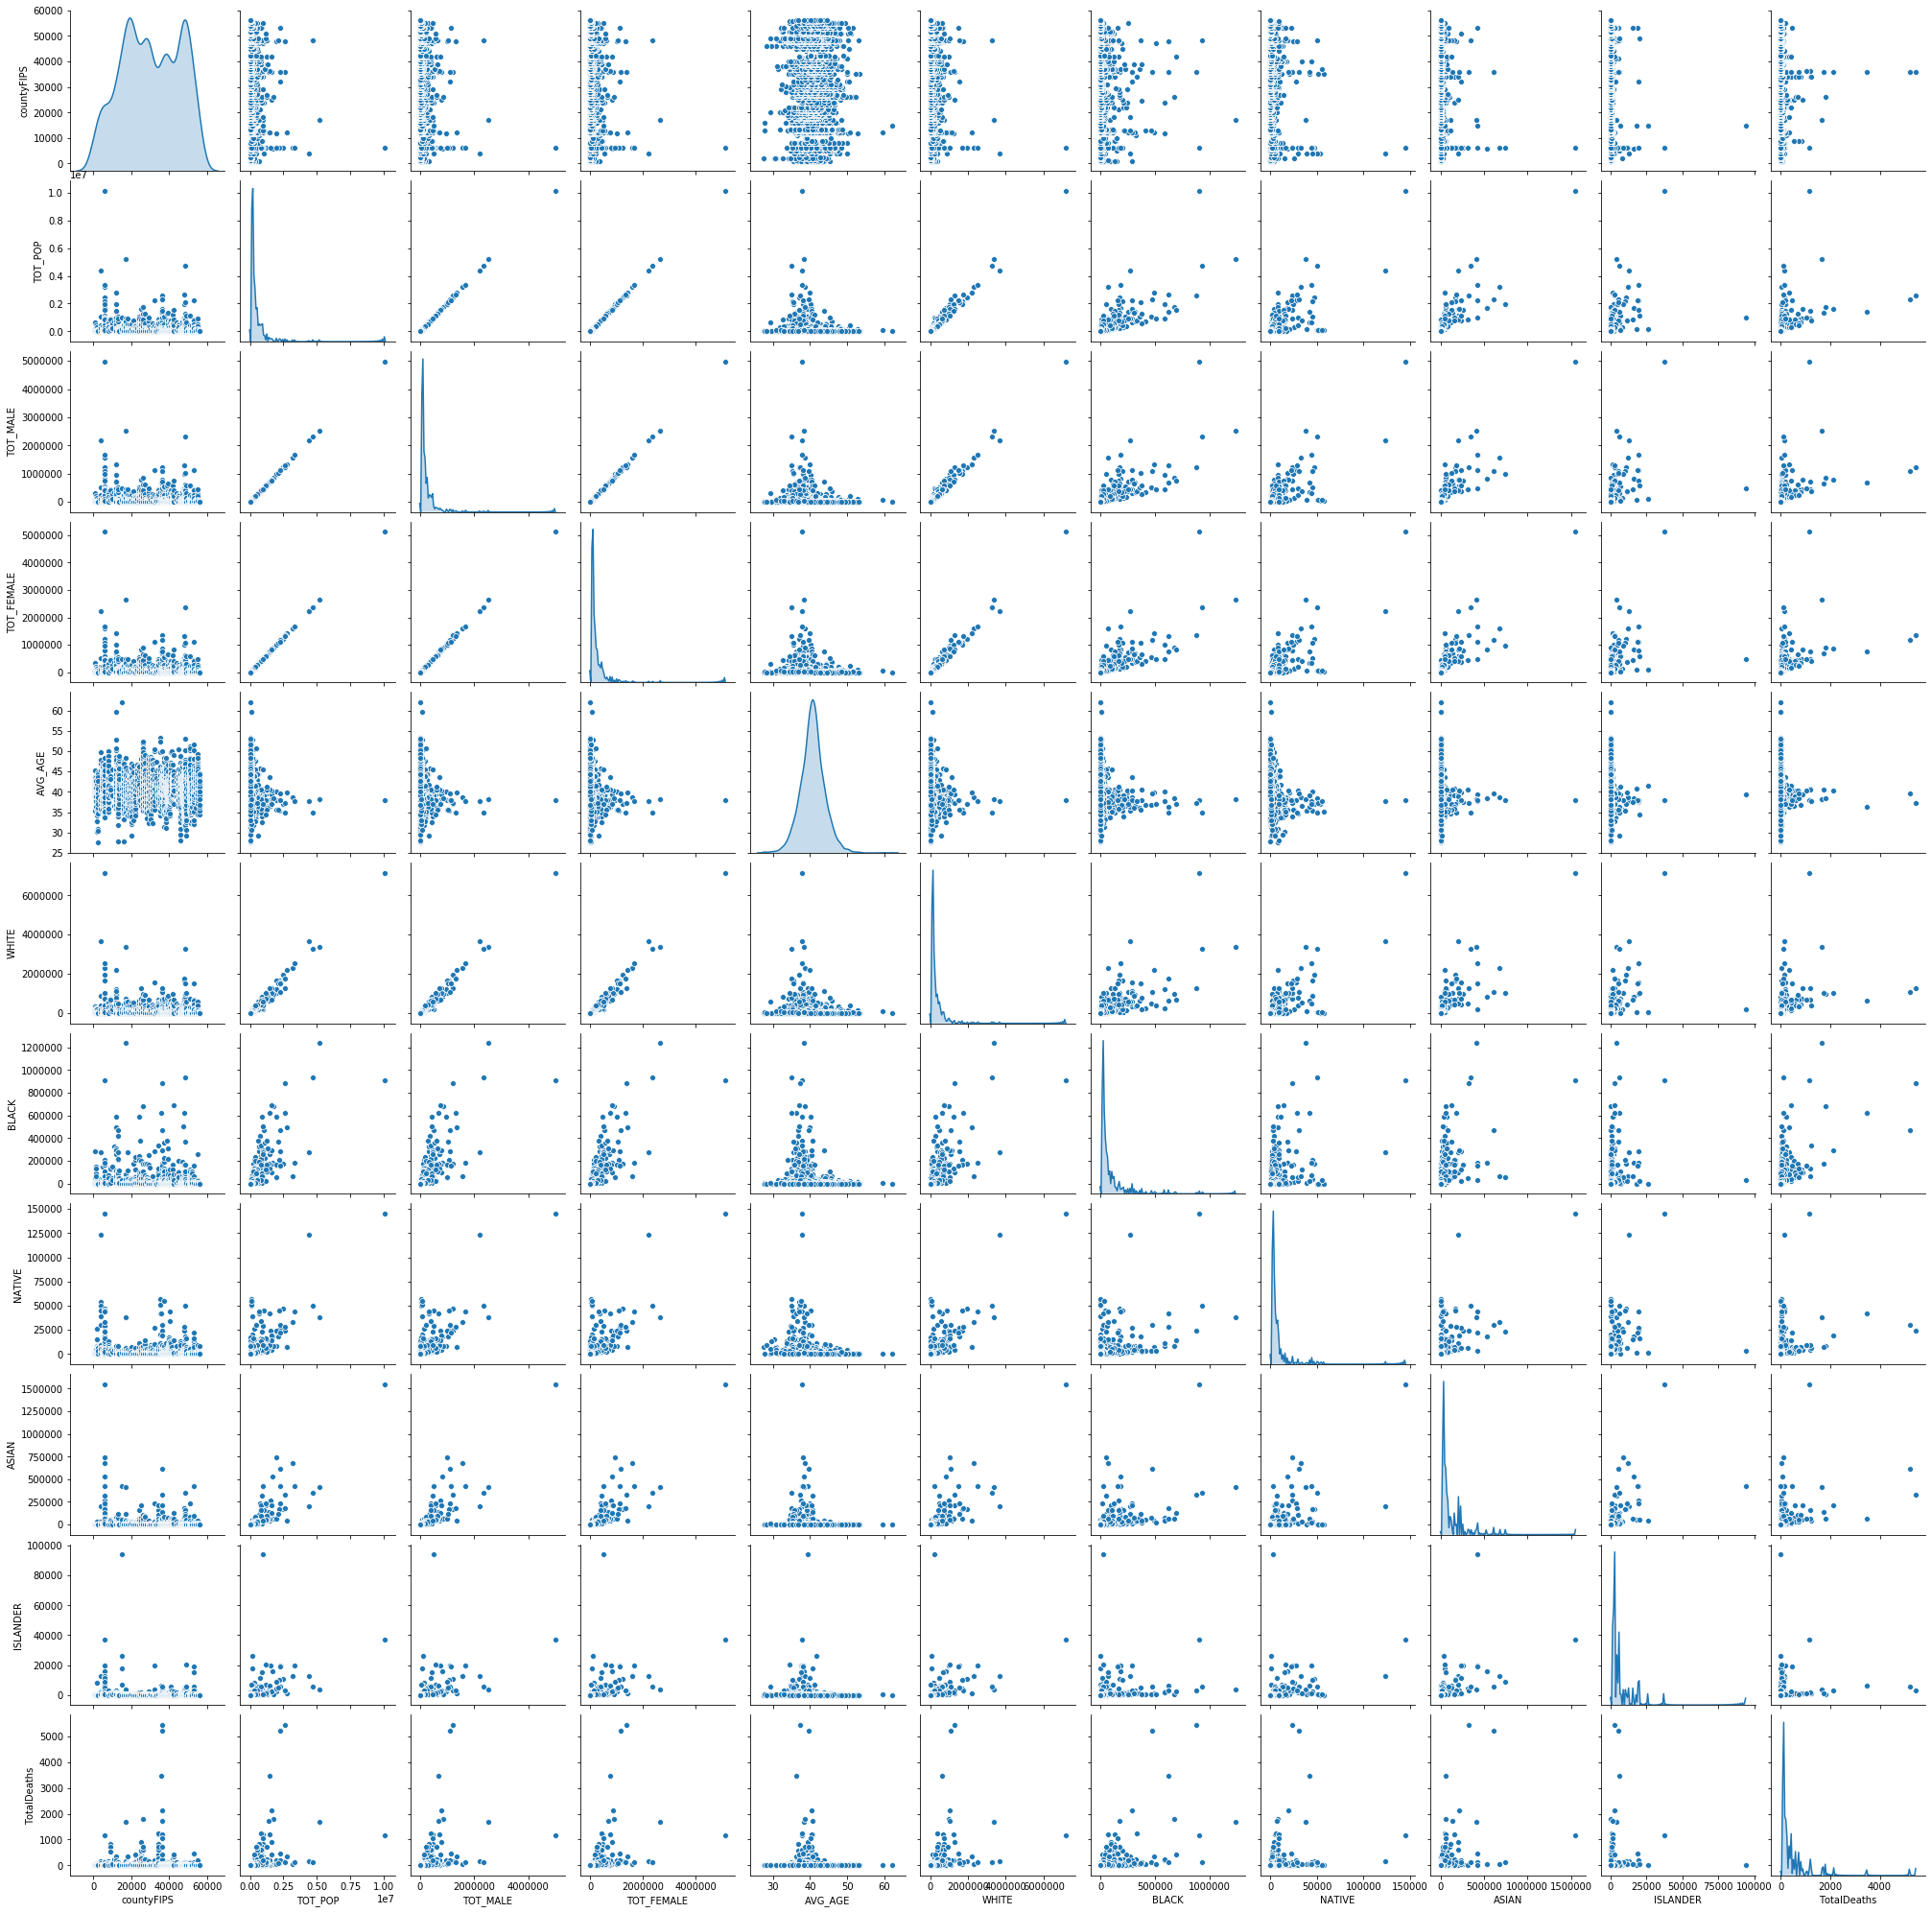

In [246]:
## creates a pairplot of the data
sb.pairplot(cleanedData, diag_kind='kde');

In [440]:
## next set up a simple model  only based on population from the original "cleaned data" just to see what the rsquared looks like
## based onnly on deaths vs total population
model_deaths_pop = smf.ols(formula='TotalDeaths~TOT_POP', data=cleanedData).fit()
model_deaths_pop.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalDeaths   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     813.9
Date:                Mon, 04 May 2020   Prob (F-statistic):          2.23e-159
Time:                        00:51:48   Log-Likelihood:                -20353.
No. Observations:                3142   AIC:                         4.071e+04
Df Residuals:                    3140   BIC:                         4.072e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.1955      2.943     -1.765      0.078     -10.966       0.575
TOT_POP        0.0002   8.43e-06     28.529      0.000       0.000       0.000
==============================================================================
Omnibus:                     7068.909   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         45231353.312
Skew:                          20.792   Prob(JB):                         0.00
Kurtosis:                     589.317   Cond. No.                     3.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [441]:
cleanedData.corr()

,countyFIPS,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
countyFIPS,1.000000,-0.055668,-0.055767,-0.055559,0.028736,-0.051660,-0.040806,-0.064261,-0.060848,-0.055618,-0.004827
TOT_POP,-0.055668,1.000000,0.999881,0.999889,-0.177546,0.988501,0.798716,0.748563,0.840335,0.478296,0.453700
TOT_MALE,-0.055767,0.999881,1.000000,0.999540,-0.178461,0.989347,0.792306,0.751018,0.842492,0.481873,0.446642
TOT_FEMALE,-0.055559,0.999889,0.999540,1.000000,-0.176623,0.987460,0.804728,0.746022,0.838061,0.474733,0.460414
AVG_AGE,0.028736,-0.177546,-0.178461,-0.176623,1.000000,-0.174315,-0.173159,-0.189299,-0.105378,-0.084714,-0.060456
WHITE,-0.051660,0.988501,0.989347,0.987460,-0.174315,1.000000,0.726603,0.751770,0.795608,0.445465,0.390946
BLACK,-0.040806,0.798716,0.792306,0.804728,-0.173159,0.726603,1.000000,0.492503,0.563498,0.253737,0.568297
NATIVE,-0.064261,0.748563,0.751018,0.746022,-0.189299,0.751770,0.492503,1.000000,0.638695,0.399171,0.299471
ASIAN,-0.060848,0.840335,0.842492,0.838061,-0.105378,0.795608,0.563498,0.638695,1.000000,0.590607,0.432725
ISLANDER,-0.055618,0.478296,0.481873,0.474733,-0.084714,0.445465,0.253737,0.399171,0.590607,1.000000,0.133629


5&6) Models and Analysis Part 1

I choose to do a multilinear regression model for this problem. I will describe the proccess here of what is going on in the below cells but see the comments for discussion as you follow along.

Before doing any modeling I wanted to address some of the issues identified in my EDA. The first was the issue of the skewing. I thought about my data and the nature of the pandemic and decided that any county showing 0 deaths should be removed from the dataset. I did this becauese it seems more likely that the county has very few to no cases or isn't far enough along the curve to generate any deaths rather than the demographic makeup of that county providing immunnity to the virus. This ends up elimininating about half of my dataset but I think it was the proper design choice.

I still have skew after dropping the zeros so I decide to try out transforming the TotalDeath information.



The first transformation I tried was a log transformation which still has a left skew on total deaths but it does help normalize the values and especially throughout the pairplot you can see the scatterplots for the features become much tighter grouped and it looks like a regression will actually fit the data relatively well.

I then try out a square root transformation as I was concerned the log transformation still had a skewed distribution of total deaths. This ended up having a large outlier on the total death distribution that looked like it could be easily dealt with but the pairplot also showed that this transformation didn't do as good of a job of grouping up the features so I decided to model the logistic regression.




see below for part 2



In [254]:
## looking at our data before we deal with covariance or anything we need to address a couple issues
## first there are a ton of 0 death counties. I don't believe the 0 death counties should be included in the model
## it is more likely the virus hasn't spread here or there is no testing rather than some sort of immunity
cleanedData_no_zeros = cleanedData[cleanedData.TotalDeaths != 0].copy()
cleanedData_no_zeros.reset_index()

,index,countyFIPS,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
0,0,1001,55601,26995,28606,38.851406,42660,10915,267,681,62,3
1,1,1003,218022,105657,112365,41.646504,190301,19492,1684,2508,146,4
2,2,1005,24881,13133,11748,40.806720,12209,12042,164,113,46,1
3,6,1013,19680,9165,10515,41.225610,10283,8839,74,259,10,1
4,7,1015,114277,54914,59363,39.963807,86026,24153,617,1102,126,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1469,3117,55139,171020,86063,84957,39.332593,157410,3959,1276,5209,91,1
1470,3125,56013,39531,19826,19705,39.149958,29180,238,8731,191,23,4
1471,3128,56019,8460,4265,4195,43.346927,8053,65,143,60,1,1
1472,3129,56021,98976,50170,48806,38.439187,90736,2711,1158,1352,133,1


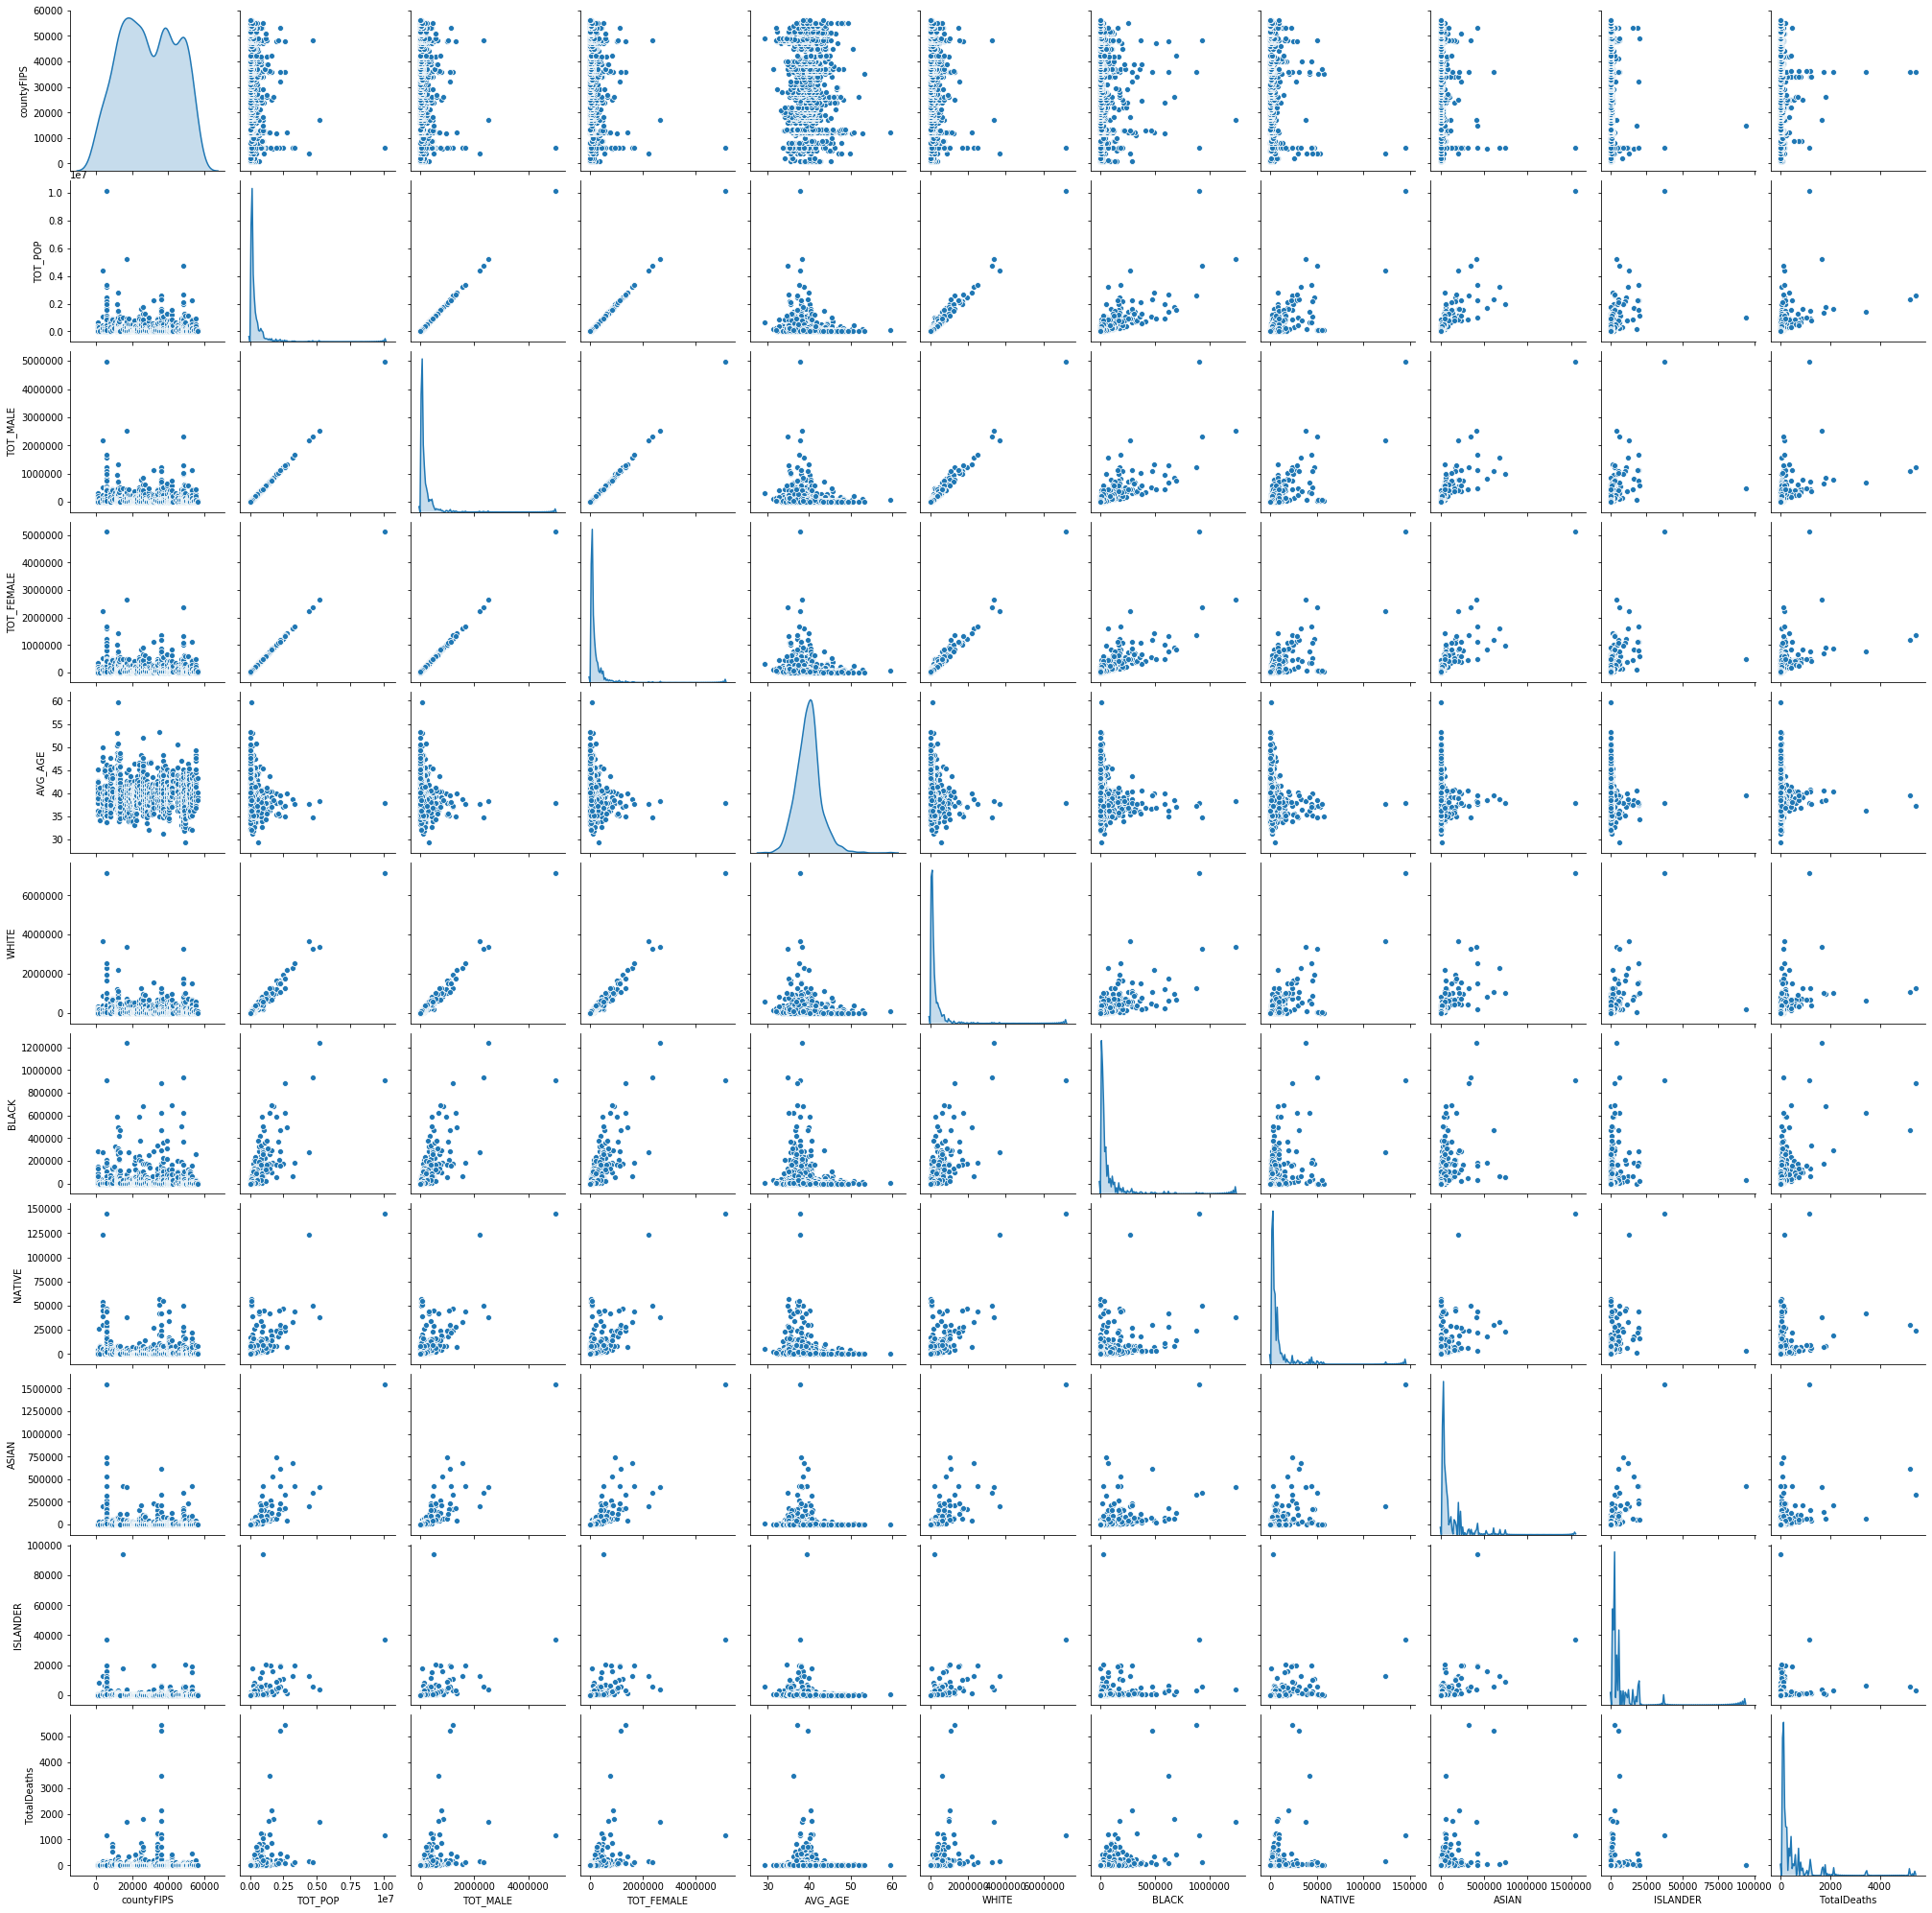

In [255]:
## based on the number of rows this eliminates about half of our dataset which is what we wanted
## rerunning the pair plot on the dataset with no zero death counties results in the below
sb.pairplot(cleanedData_no_zeros, diag_kind='kde');

In [439]:
## rerunning to see the effect on a simple regression based on population 
model_deaths_pop_no_zeros = smf.ols(formula='TotalDeaths~TOT_POP', data=cleanedData_no_zeros).fit()
model_deaths_pop_no_zeros.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalDeaths   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     356.6
Date:                Mon, 04 May 2020   Prob (F-statistic):           2.12e-71
Time:                        00:51:38   Log-Likelihood:                -10106.
No. Observations:                1474   AIC:                         2.022e+04
Df Residuals:                    1472   BIC:                         2.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.3064      6.496     -0.817      0.414     -18.049       7.436
TOT_POP        0.0002   1.28e-05     18.885      0.000       0.000       0.000
==============================================================================
Omnibus:                     2824.968   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4644747.859
Skew:                          14.237   Prob(JB):                         0.00
Kurtosis:                     276.525   Cond. No.                     5.52e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

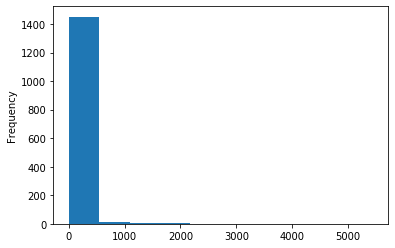

In [273]:
## plotted the histogram of the totaldeaths and its still very skewed left
cleanedData_no_zeros['TotalDeaths'].plot(kind= 'hist')

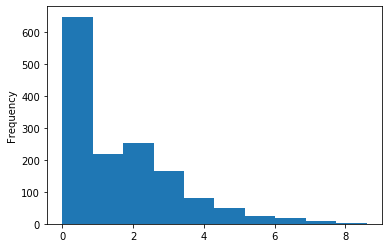

In [346]:
## eliminating the 0's made the simple regression results on population slightly worse likely due to decreased sample size
## rather than this being a bad design choice
## since the distribution of total deaths is still heavily skewed to lower values I will try log transforming the death column
cleanedData_log = cleanedData_no_zeros.copy()
cleanedData_log = cleanedData_log.reset_index()
cleanedData_log['TotalDeaths'] = np.log(cleanedData_log['TotalDeaths'])
cleanedData_log['TotalDeaths'].plot(kind = 'hist')

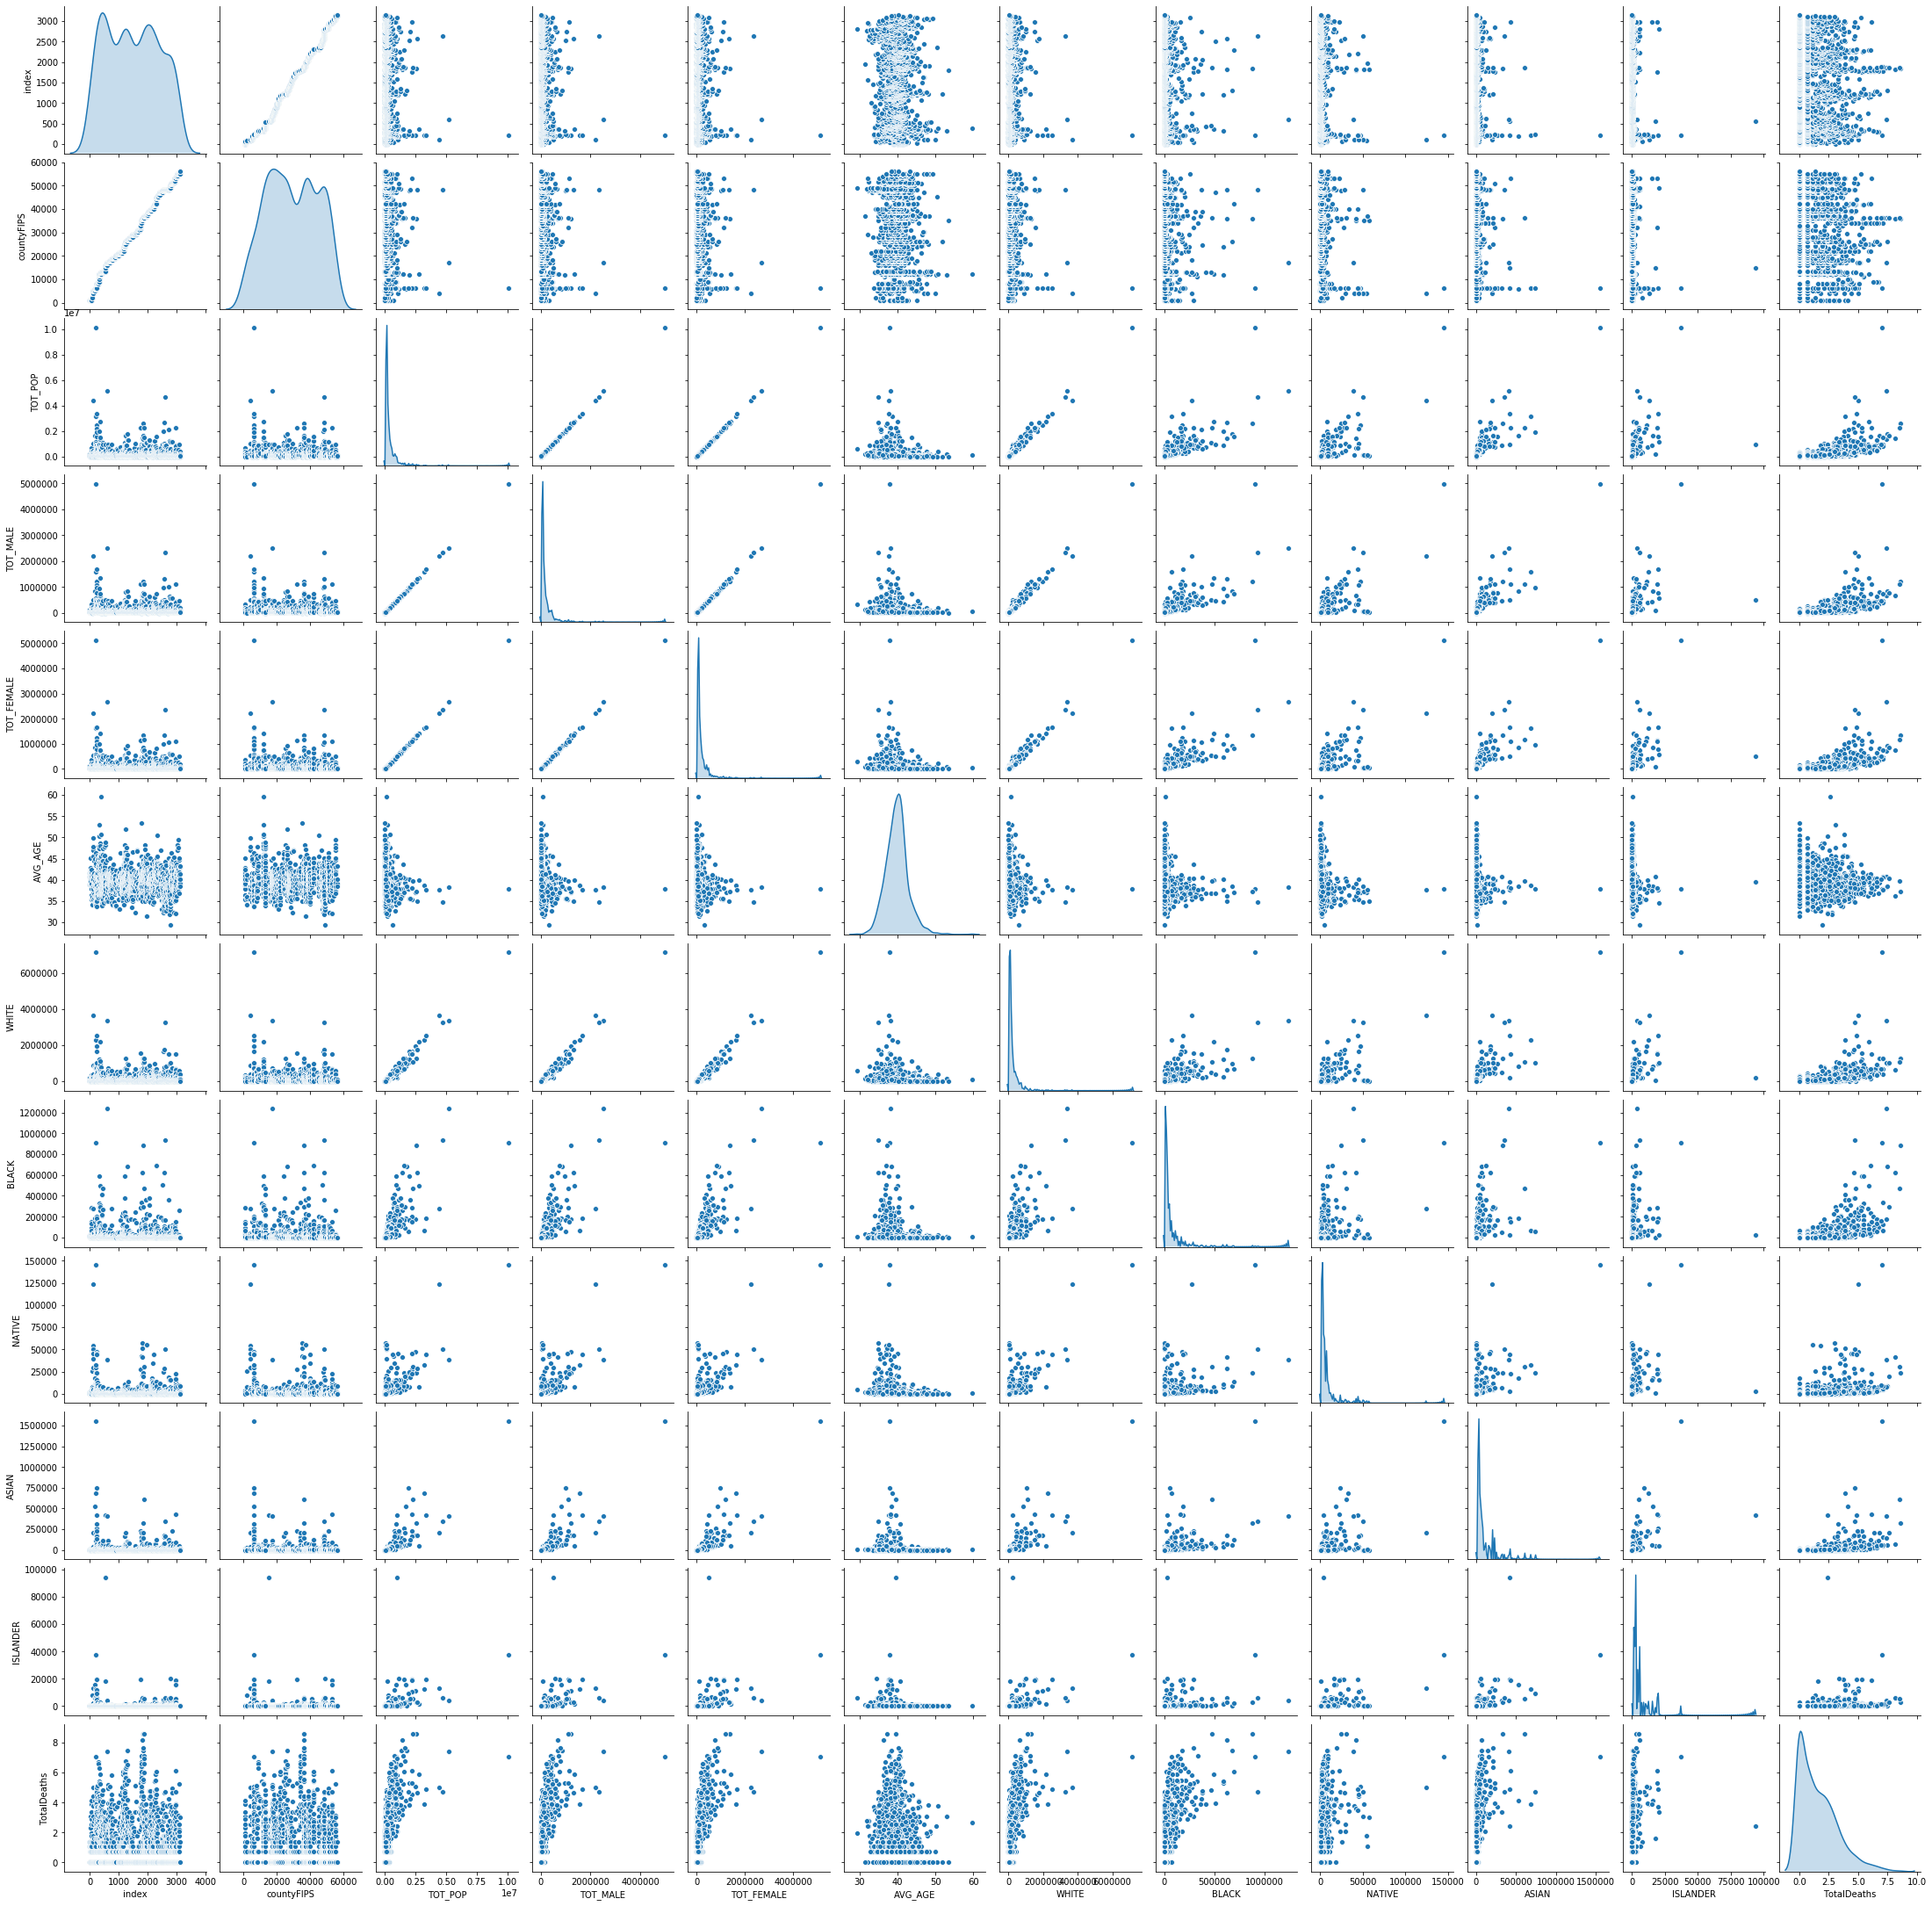

In [347]:
## this looked a bit better but still skewed left
## trying pair plot based on the log data
sb.pairplot(cleanedData_log, diag_kind='kde');

In [348]:
## try the simple linear model on it
## looks like we are heading in the right direction
model_deaths_log = smf.ols(formula='TotalDeaths~TOT_POP', data=cleanedData_log).fit()
model_deaths_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalDeaths   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     649.5
Date:                Sun, 03 May 2020   Prob (F-statistic):          5.63e-119
Time:                        20:40:13   Log-Likelihood:                -2541.2
No. Observations:                1474   AIC:                             5086.
Df Residuals:                    1472   BIC:                             5097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2271      0.038     31.984      0.000       1.152       1.302
TOT_POP     1.922e-06   7.54e-08     25.485      0.000    1.77e-06    2.07e-06
==============================================================================
Omnibus:                      210.696   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2803.615
Skew:                          -0.024   Prob(JB):                         0.00
Kurtosis:                       9.756   Cond. No.                     5.52e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

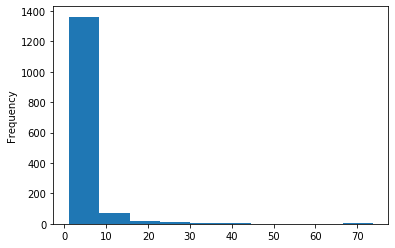

In [390]:
## that helped but decided to see if sqrt transformation would be better
cleanedData_sqrt = cleanedData_no_zeros.copy()
cleanedData_sqrt = cleanedData_sqrt.reset_index()
cleanedData_sqrt['TotalDeaths'] = np.sqrt(cleanedData_sqrt['TotalDeaths'])
cleanedData_sqrt['TotalDeaths'].plot(kind = 'hist')


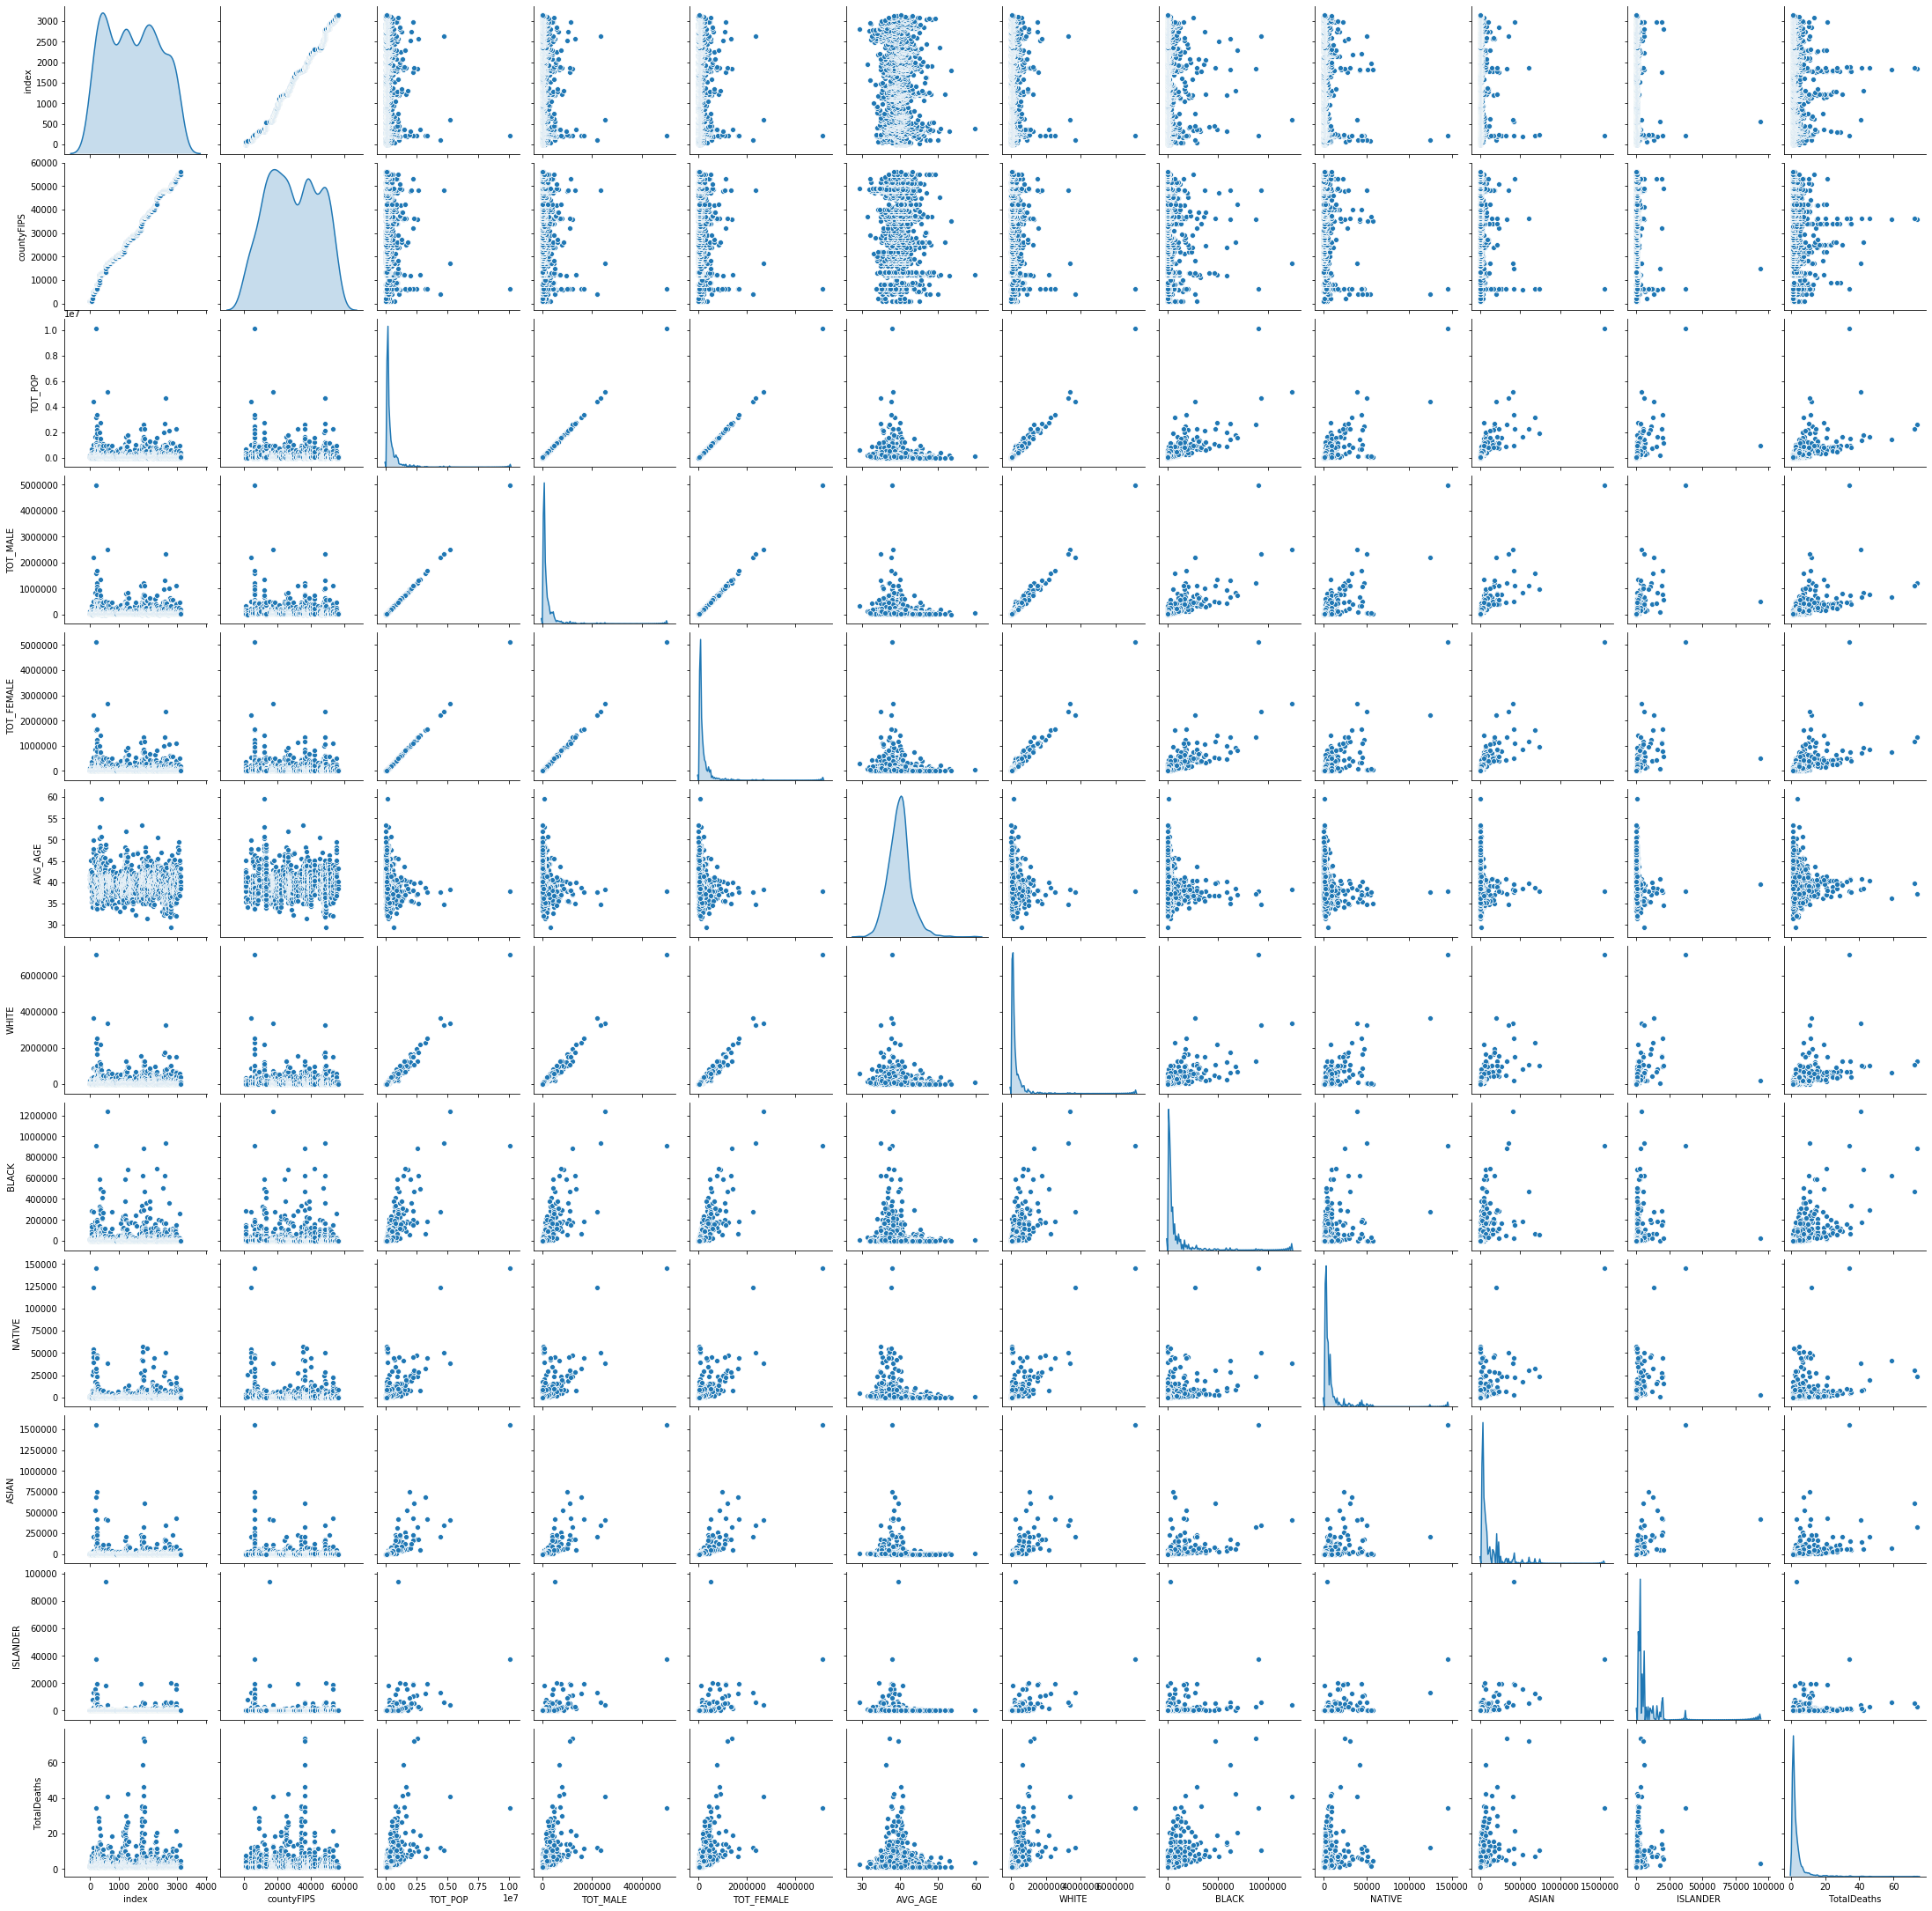

In [391]:
sb.pairplot(cleanedData_sqrt, diag_kind='kde');

In [392]:
model_deaths_sqrt = smf.ols(formula='TotalDeaths~TOT_POP', data=cleanedData_sqrt).fit()
model_deaths_sqrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalDeaths   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     844.1
Date:                Sun, 03 May 2020   Prob (F-statistic):          4.55e-147
Time:                        21:23:12   Log-Likelihood:                -4265.2
No. Observations:                1474   AIC:                             8534.
Df Residuals:                    1472   BIC:                             8545.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1047      0.124     17.033      0.000       1.862       2.347
TOT_POP     7.057e-06   2.43e-07     29.053      0.000    6.58e-06    7.53e-06
==============================================================================
Omnibus:                     1524.634   Durbin-Watson:                   1.525
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183283.623
Skew:                           4.696   Prob(JB):                         0.00
Kurtosis:                      56.815   Cond. No.                     5.52e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

5&6) Models and Analysis: Part 2

The sqrt had a stronger simple model but based on analysis looking at the pairplots the log transformation does a better job of dealing with outliers across all the variables so I have choosen to model this data.

Quick note on feature engineering before digging into models. The AVG_AGE column and the racial breakouts were all engineered in my initial cleaning and combining of the dataset. They were not found in the current form originally as I had to calculate the average age from 15 ranges of age groups and I combined the male and female race components into one to simplify the dataset. 

Multilinear Regression with Log Transformed Data:

Now that we have somewhat addressed the skew problem we have to look to the colinearity issues identified previously. The first thing I do is drop TOT_POP from the model completly as it is highly coorelated with all the other variables and i think the effect of population will be accounted for by the indivdual features. The issue is that tot_male and tot_female seem highly colinear with each of the categories as well and to handle this I decided to use interaction terms in the model for male/female and each racial category.

I run the first model with all the interaction terms and acheive an Rsquared of .541 which is ok but not great. I also have 18 features/interactions so its pretty complex. I am able to eliminate the 3 'Asian' features and the avg_age feature as none of their p-values are statistically significant. However due to the hierarhcy rules the rest of the features need to stay. 

I rerun the model and the Rsquared drops slighlty to .52 but we have eliminated 4 featurs which seems a fair tradeoff. Also the .52 is much better than the simple linear regression value of .2 I obtained above between only population and total deaths. This means the extra demographic dats is adding about .3 to the predictive value of the model over just raw population numbers. 

The Rsquared and coefficients are only one metric to evaluate our model so I plot the QQplot next which suggests that the data does skew a little but it appears to be acceptably normally distributed to use linear regression.

I then want to check the leverage vs residuals to see if we have any outliers or other data points that are affecting our data. This plot identifies 10 points i remove from the dataset.

I then rerun the model using the reduced dataset and acheive an Rsquared of .56 which is a little bit of an improvement over the original model. After checking the qqplot (which flattened a little which is a good result compared to the first) and the residuals plot I decided I didn't want to remove any more data points as the main outliers had already been removed. 

The Rsquared value of .56 indicates that this model has an ok amount of predictive power but it isn't fantastic. If we look at the coeeficients (remembering these need to have the log function reveresed which is why the values are so small) it appears that higher levels of a black population in a given county is linked to higher incidence of COVID 19 death in said county by a log factor of between 2-3 times the white and native population coefficients. 


I also ran this analaysis on the square root transformed data below as I thought it might deal with the skew I couldn't remove from the log transformed data. You can see the results below but in short, while the rsquared values were better the qqplots showed that the residuals were not normally distributed which made me uncomfortable standing by the regression model for this data as that violates one of the key regression assumptions. Due to this fact I am submitting the Multilinear Regression Log Transformed model with the 10 levereged points eliminated as my final model. 

See conclusion below.





In [393]:
## print out the coorelation matrix of the log transformed data I have decided to use
cleanedData_log.corr()

,index,countyFIPS,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
index,1.000000,0.996082,-0.055032,-0.055005,-0.055045,-0.019536,-0.049148,-0.040278,-0.061116,-0.068693,-0.058388,-0.090794
countyFIPS,0.996082,1.000000,-0.056606,-0.056774,-0.056431,-0.010240,-0.051008,-0.035816,-0.071619,-0.073781,-0.062898,-0.087265
TOT_POP,-0.055032,-0.056606,1.000000,0.999875,0.999883,-0.179608,0.987779,0.787419,0.748514,0.841746,0.480135,0.553299
TOT_MALE,-0.055005,-0.056774,0.999875,1.000000,0.999516,-0.180873,0.988699,0.780614,0.751094,0.843971,0.483930,0.549573
TOT_FEMALE,-0.055045,-0.056431,0.999883,0.999516,1.000000,-0.178342,0.986656,0.793807,0.745842,0.839395,0.476353,0.556768
AVG_AGE,-0.019536,-0.010240,-0.179608,-0.180873,-0.178342,1.000000,-0.169878,-0.190649,-0.189268,-0.115116,-0.096070,-0.177438
WHITE,-0.049148,-0.051008,0.987779,0.988699,0.986656,-0.169878,1.000000,0.710874,0.752771,0.796262,0.446842,0.539890
BLACK,-0.040278,-0.035816,0.787419,0.780614,0.793807,-0.190649,0.710874,1.000000,0.479045,0.551466,0.244179,0.539508
NATIVE,-0.061116,-0.071619,0.748514,0.751094,0.745842,-0.189268,0.752771,0.479045,1.000000,0.638130,0.403116,0.343019
ASIAN,-0.068693,-0.073781,0.841746,0.843971,0.839395,-0.115116,0.796262,0.551466,0.638130,1.000000,0.595719,0.381755


In [394]:
## looks like we have quite the colinearity problem which is to be expected since all of our data 
## is based on population. Will drop the total population from the model as it has the highest coorelations
## additionally will use interaction terms between each race and male/female to handle the coliniarity there
cleanedData_log[['TOT_MALE','TOT_FEMALE','AVG_AGE','WHITE','BLACK','NATIVE','ASIAN','ISLANDER','TotalDeaths']].corr()

,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
TOT_MALE,1.000000,0.999516,-0.180873,0.988699,0.780614,0.751094,0.843971,0.483930,0.549573
TOT_FEMALE,0.999516,1.000000,-0.178342,0.986656,0.793807,0.745842,0.839395,0.476353,0.556768
AVG_AGE,-0.180873,-0.178342,1.000000,-0.169878,-0.190649,-0.189268,-0.115116,-0.096070,-0.177438
WHITE,0.988699,0.986656,-0.169878,1.000000,0.710874,0.752771,0.796262,0.446842,0.539890
BLACK,0.780614,0.793807,-0.190649,0.710874,1.000000,0.479045,0.551466,0.244179,0.539508
NATIVE,0.751094,0.745842,-0.189268,0.752771,0.479045,1.000000,0.638130,0.403116,0.343019
ASIAN,0.843971,0.839395,-0.115116,0.796262,0.551466,0.638130,1.000000,0.595719,0.381755
ISLANDER,0.483930,0.476353,-0.096070,0.446842,0.244179,0.403116,0.595719,1.000000,0.194448
TotalDeaths,0.549573,0.556768,-0.177438,0.539890,0.539508,0.343019,0.381755,0.194448,1.000000


In [395]:
## even with population dropped still really high. Need to use the interaction terms as I mentioned
## generating the "simple" model with all the interactions accounted for
model_deaths_log_1 = smf.ols(formula='TotalDeaths~AVG_AGE+(TOT_MALE*WHITE)+(TOT_FEMALE*WHITE)+(TOT_MALE*BLACK)+(TOT_FEMALE*BLACK)+(TOT_MALE*NATIVE)+(TOT_FEMALE*NATIVE)+(TOT_MALE*ASIAN)+(TOT_FEMALE*ASIAN)+(TOT_MALE*ISLANDER)+(TOT_MALE*ISLANDER)+(TOT_FEMALE*ISLANDER)', data=cleanedData_log).fit()
model_deaths_log_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalDeaths   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     95.37
Date:                Sun, 03 May 2020   Prob (F-statistic):          9.49e-231
Time:                        21:23:21   Log-Likelihood:                -2236.3
No. Observations:                1474   AIC:                             4511.
Df Residuals:                    1455   BIC:                             4611.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.4269      0.437      3.262      0.001       0.569       2.285
AVG_AGE                -0.0160      0.011     -1.493      0.136      -0.037       0.005
TOT_MALE            -5.006e-05   1.54e-05     -3.250      0.001   -8.03e-05   -1.98e-05
WHITE                1.925e-05   1.28e-05      1.509      0.132   -5.77e-06    4.43e-05
TOT_MALE:WHITE      -3.371e-11   1.04e-11     -3.245      0.001   -5.41e-11   -1.33e-11
TOT_FEMALE           2.374e-05   1.64e-05      1.448      0.148   -8.42e-06    5.59e-05
TOT_FEMALE:WHITE     2.814e-11    9.8e-12      2.872      0.004    8.92e-12    4.74e-11
BLACK                1.911e-05   1.28e-05      1.491      0.136   -6.02e-06    4.42e-05
TOT_MALE:BLACK       1.242e-10   2.17e-11      5.721      0.000    8.16e-11    1.67e-10
TOT_FEMALE:BLACK    -1.208e-10   2.08e-11     -5.821      0.000   -1.62e-10   -8.01e-11
NATIVE               1.687e-05   1.61e-05      1.047      0.295   -1.47e-05    4.85e-05
TOT_MALE:NATIVE     -1.292e-09   5.68e-10     -2.274      0.023   -2.41e-09   -1.78e-10
TOT_FEMALE:NATIVE    1.321e-09   5.51e-10      2.396      0.017     2.4e-10     2.4e-09
ASIAN                5.562e-06   1.35e-05      0.413      0.680   -2.09e-05     3.2e-05
TOT_MALE:ASIAN       1.811e-11   3.22e-11      0.563      0.574    -4.5e-11    8.12e-11
TOT_FEMALE:ASIAN     -5.13e-12   3.13e-11     -0.164      0.870   -6.65e-11    5.62e-11
ISLANDER            -4.813e-05   4.87e-05     -0.988      0.323      -0.000    4.74e-05
TOT_MALE:ISLANDER    6.723e-09   1.37e-09      4.906      0.000    4.03e-09    9.41e-09
TOT_FEMALE:ISLANDER -6.581e-09   1.35e-09     -4.862      0.000   -9.24e-09   -3.93e-09
==============================================================================
Omnibus:                       52.927   Durbin-Watson:                   1.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.964
Skew:                           0.484   Prob(JB):                     2.59e-13
Kurtosis:                       3.069   Cond. No.                     2.29e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [396]:
## we eliminate terms that are not statistically significant based on there p-values
##note due to the hiearchy rules if we keep a combination we need to keep all the subterms
## based on the above model we eliminate the asian terms and the avg_age term
## this leaves us with a slightly smaller rsquared of .524 but eliminats 3 terms out of our model
model_deaths_log_2 = smf.ols(formula='TotalDeaths~(TOT_MALE*WHITE)+(TOT_FEMALE*WHITE)+(TOT_MALE*BLACK)+(TOT_FEMALE*BLACK)+(TOT_MALE*NATIVE)+(TOT_FEMALE*NATIVE)+(TOT_MALE*ISLANDER)+(TOT_MALE*ISLANDER)+(TOT_FEMALE*ISLANDER)', data=cleanedData_log).fit()
model_deaths_log_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalDeaths   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     114.9
Date:                Sun, 03 May 2020   Prob (F-statistic):          1.70e-223
Time:                        21:23:24   Log-Likelihood:                -2262.9
No. Observations:                1474   AIC:                             4556.
Df Residuals:                    1459   BIC:                             4635.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8681      0.037     23.520      0.000       0.796       0.941
TOT_MALE            -2.765e-05   9.57e-06     -2.890      0.004   -4.64e-05   -8.88e-06
WHITE                2.877e-06   1.15e-06      2.502      0.012    6.22e-07    5.13e-06
TOT_MALE:WHITE      -2.635e-11   1.03e-11     -2.565      0.010   -4.65e-11    -6.2e-12
TOT_FEMALE            3.09e-05    9.6e-06      3.219      0.001    1.21e-05    4.97e-05
TOT_FEMALE:WHITE     2.334e-11   9.73e-12      2.399      0.017    4.26e-12    4.24e-11
BLACK                 4.67e-06   1.59e-06      2.935      0.003    1.55e-06    7.79e-06
TOT_MALE:BLACK       1.268e-10    2.2e-11      5.767      0.000    8.36e-11     1.7e-10
TOT_FEMALE:BLACK     -1.25e-10    2.1e-11     -5.958      0.000   -1.66e-10   -8.39e-11
NATIVE               4.229e-06   7.62e-06      0.555      0.579   -1.07e-05    1.92e-05
TOT_MALE:NATIVE     -2.243e-09   5.62e-10     -3.994      0.000   -3.34e-09   -1.14e-09
TOT_FEMALE:NATIVE    2.197e-09   5.46e-10      4.020      0.000    1.12e-09    3.27e-09
ISLANDER               -0.0002   3.49e-05     -6.294      0.000      -0.000      -0.000
TOT_MALE:ISLANDER    4.832e-09   1.29e-09      3.731      0.000    2.29e-09    7.37e-09
TOT_FEMALE:ISLANDER -4.455e-09   1.27e-09     -3.515      0.000   -6.94e-09   -1.97e-09
==============================================================================
Omnibus:                       55.026   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.646
Skew:                           0.497   Prob(JB):                     6.77e-14
Kurtosis:                       3.017   Cond. No.                     1.87e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

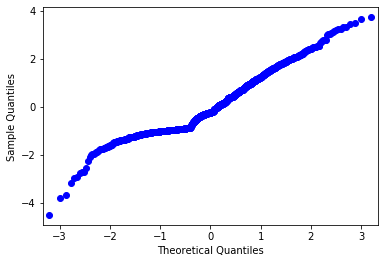

In [353]:
## lets take a look at some diagnostics to ensure the model is behaving apporopriately
sm.qqplot(model_deaths_log_2.resid);

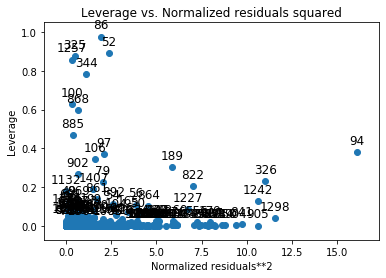

In [354]:
## the qq plot indicates a the data is skewed to the left for the earlier quantiles which we knew already 
## beseides the slight skew it doesn't jump out as non normal 
## try a leverage model next
sm.graphics.plot_leverage_resid2(model_deaths_log_2, alpha=0.05);

In [359]:
##based on this result we get teh follow ing points as "outliers"
cleanedData_log.iloc[[86,52,325,1257,344,100,868,885,94,97]]

,index,countyFIPS,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
86,204,6037,10105518,4981895,5123623,37.860876,7151444,906467,145254,1551894,37200,7.066467
52,103,4013,4410824,2181718,2229106,37.756130,3663379,275869,123814,202798,12814,4.990433
325,547,15003,980080,492574,487506,39.482318,212694,27758,3210,420967,94079,2.397895
1257,2623,48201,4698619,2333866,2364753,34.819834,3268948,933703,49922,348874,5865,4.736198
344,610,17031,5180493,2516081,2664412,38.272575,3391043,1236170,38253,408151,3873,7.422374
100,222,6073,3343364,1682449,1660915,37.678646,2522987,184779,44035,420909,19678,4.897840
868,1830,36005,1432132,674900,757232,36.284839,642607,624800,41726,64447,5940,8.148156
885,1851,36047,2582830,1223764,1359066,37.220433,1278770,881296,23841,327010,2961,8.602637
94,215,6059,3185968,1572801,1613167,38.666960,2278624,67789,32905,681242,12403,3.912023
97,219,6067,1540975,752972,788003,37.595234,970616,167528,23734,260762,19726,3.737670


In [363]:
## above shows the data for the 10 biggest outliers based on the residual vs leverage plot. 
## will remove these from the data set and see if it improves our modeling
cleanedData_log_unlever = cleanedData_log.copy()
cleanedData_log_unlever = cleanedData_log_unlever.drop([86,52,325,1257,344,100,868,885,94,97])
cleanedData_log_unlever

,index,countyFIPS,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
0,0,1001,55601,26995,28606,38.851406,42660,10915,267,681,62,1.098612
1,1,1003,218022,105657,112365,41.646504,190301,19492,1684,2508,146,1.386294
2,2,1005,24881,13133,11748,40.806720,12209,12042,164,113,46,0.000000
3,6,1013,19680,9165,10515,41.225610,10283,8839,74,259,10,0.000000
4,7,1015,114277,54914,59363,39.963807,86026,24153,617,1102,126,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...
1469,3117,55139,171020,86063,84957,39.332593,157410,3959,1276,5209,91,0.000000
1470,3125,56013,39531,19826,19705,39.149958,29180,238,8731,191,23,1.386294
1471,3128,56019,8460,4265,4195,43.346927,8053,65,143,60,1,0.000000
1472,3129,56021,98976,50170,48806,38.439187,90736,2711,1158,1352,133,0.000000


In [365]:
## rerunning reduced dataset with previous model
model_deaths_log_2_unlever = smf.ols(formula='TotalDeaths~(TOT_MALE*WHITE)+(TOT_FEMALE*WHITE)+(TOT_MALE*BLACK)+(TOT_FEMALE*BLACK)+(TOT_MALE*NATIVE)+(TOT_FEMALE*NATIVE)+(TOT_MALE*ISLANDER)+(TOT_MALE*ISLANDER)+(TOT_FEMALE*ISLANDER)', data=cleanedData_log_unlever).fit()
model_deaths_log_2_unlever.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalDeaths   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     129.6
Date:                Sun, 03 May 2020   Prob (F-statistic):          2.02e-243
Time:                        20:49:37   Log-Likelihood:                -2163.9
No. Observations:                1464   AIC:                             4358.
Df Residuals:                    1449   BIC:                             4437.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6881      0.038     18.001      0.000       0.613       0.763
TOT_MALE            -3.838e-05   1.21e-05     -3.169      0.002   -6.21e-05   -1.46e-05
WHITE                1.369e-06    1.2e-06      1.142      0.254   -9.84e-07    3.72e-06
TOT_MALE:WHITE       -2.45e-12   2.25e-11     -0.109      0.913   -4.67e-11    4.18e-11
TOT_FEMALE           4.726e-05   1.22e-05      3.886      0.000    2.34e-05    7.11e-05
TOT_FEMALE:WHITE    -1.396e-12   2.15e-11     -0.065      0.948   -4.35e-11    4.07e-11
BLACK                3.416e-06   1.97e-06      1.735      0.083   -4.47e-07    7.28e-06
TOT_MALE:BLACK       9.363e-11   3.61e-11      2.596      0.010    2.29e-11    1.64e-10
TOT_FEMALE:BLACK    -9.637e-11   3.43e-11     -2.808      0.005   -1.64e-10   -2.91e-11
NATIVE               1.499e-05   8.15e-06      1.840      0.066    -9.9e-07     3.1e-05
TOT_MALE:NATIVE     -9.783e-10   8.28e-10     -1.182      0.237    -2.6e-09    6.45e-10
TOT_FEMALE:NATIVE    9.245e-10   8.02e-10      1.153      0.249   -6.48e-10     2.5e-09
ISLANDER               -0.0001   4.61e-05     -2.895      0.004      -0.000   -4.31e-05
TOT_MALE:ISLANDER    5.209e-09   2.41e-09      2.164      0.031    4.86e-10    9.93e-09
TOT_FEMALE:ISLANDER  -5.07e-09   2.39e-09     -2.124      0.034   -9.75e-09   -3.88e-10
==============================================================================
Omnibus:                       60.875   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.729
Skew:                           0.512   Prob(JB):                     3.24e-15
Kurtosis:                       2.784   Cond. No.                     3.78e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

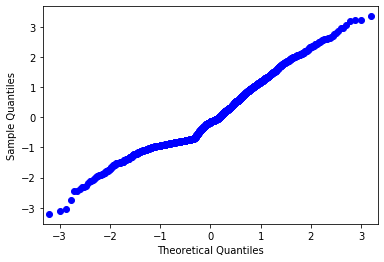

In [367]:
## this slightly improves our model so lets check our results again
sm.qqplot(model_deaths_log_2_unlever.resid);

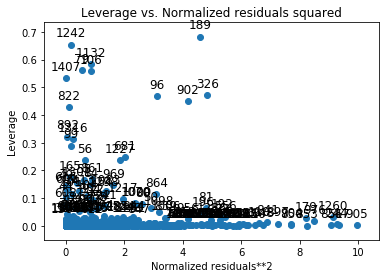

In [368]:
## looks like we got a slightly more normal looking result which is good
sm.graphics.plot_leverage_resid2(model_deaths_log_2_unlever, alpha=0.05);

In [369]:
## still have some outliers but the scale changed. Not going to keep removing data as already cut off the 10 worst offenders
## considering this the best the multilinear regression is going to get

In [377]:
## afraid that the log transformation didn't do a good enough job of dealing with skew going to try to use the sqrt data to see if its better
cleanedData_sqrt.corr()

,countyFIPS,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
countyFIPS,1.000000,-0.056606,-0.056774,-0.056431,-0.010240,-0.051008,-0.035816,-0.071619,-0.073781,-0.062898,-0.033464
TOT_POP,-0.056606,1.000000,0.999875,0.999883,-0.179608,0.987779,0.787419,0.748514,0.841746,0.480135,0.603692
TOT_MALE,-0.056774,0.999875,1.000000,0.999516,-0.180873,0.988699,0.780614,0.751094,0.843971,0.483930,0.597165
TOT_FEMALE,-0.056431,0.999883,0.999516,1.000000,-0.178342,0.986656,0.793807,0.745842,0.839395,0.476353,0.609854
AVG_AGE,-0.010240,-0.179608,-0.180873,-0.178342,1.000000,-0.169878,-0.190649,-0.189268,-0.115116,-0.096070,-0.108659
WHITE,-0.051008,0.987779,0.988699,0.986656,-0.169878,1.000000,0.710874,0.752771,0.796262,0.446842,0.559348
BLACK,-0.035816,0.787419,0.780614,0.793807,-0.190649,0.710874,1.000000,0.479045,0.551466,0.244179,0.657676
NATIVE,-0.071619,0.748514,0.751094,0.745842,-0.189268,0.752771,0.479045,1.000000,0.638130,0.403116,0.370708
ASIAN,-0.073781,0.841746,0.843971,0.839395,-0.115116,0.796262,0.551466,0.638130,1.000000,0.595719,0.486392
ISLANDER,-0.062898,0.480135,0.483930,0.476353,-0.096070,0.446842,0.244179,0.403116,0.595719,1.000000,0.186709


In [397]:
## as before the TOT_POP data needs to be dropped as it appears to be colinear with other columns
## running with all the interaction terms
model_deaths_sqrt_1 = smf.ols(formula='TotalDeaths~AVG_AGE+(TOT_MALE*WHITE)+(TOT_FEMALE*WHITE)+(TOT_MALE*BLACK)+(TOT_FEMALE*BLACK)+(TOT_MALE*NATIVE)+(TOT_FEMALE*NATIVE)+(TOT_MALE*ASIAN)+(TOT_FEMALE*ASIAN)+(TOT_MALE*ISLANDER)+(TOT_MALE*ISLANDER)+(TOT_FEMALE*ISLANDER)', data=cleanedData_sqrt).fit()
model_deaths_sqrt_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalDeaths   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     182.6
Date:                Sun, 03 May 2020   Prob (F-statistic):               0.00
Time:                        21:23:43   Log-Likelihood:                -3728.5
No. Observations:                1474   AIC:                             7495.
Df Residuals:                    1455   BIC:                             7596.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.4665      1.204     -0.388      0.698      -2.828       1.895
AVG_AGE                 0.0430      0.030      1.454      0.146      -0.015       0.101
TOT_MALE               -0.0003   4.24e-05     -6.219      0.000      -0.000      -0.000
WHITE                   0.0002   3.51e-05      4.493      0.000    8.89e-05       0.000
TOT_MALE:WHITE       1.259e-10   2.86e-11      4.404      0.000    6.98e-11    1.82e-10
TOT_FEMALE          -1.944e-05   4.51e-05     -0.431      0.667      -0.000    6.91e-05
TOT_FEMALE:WHITE    -1.323e-10    2.7e-11     -4.905      0.000   -1.85e-10   -7.94e-11
BLACK                   0.0002   3.53e-05      4.490      0.000    8.91e-05       0.000
TOT_MALE:BLACK       1.074e-10   5.97e-11      1.798      0.072   -9.79e-12    2.25e-10
TOT_FEMALE:BLACK    -1.088e-10   5.71e-11     -1.905      0.057   -2.21e-10    3.22e-12
NATIVE                  0.0001   4.43e-05      3.270      0.001     5.8e-05       0.000
TOT_MALE:NATIVE     -1.778e-08   1.56e-09    -11.376      0.000   -2.09e-08   -1.47e-08
TOT_FEMALE:NATIVE    1.751e-08   1.52e-09     11.541      0.000    1.45e-08    2.05e-08
ASIAN                   0.0002   3.71e-05      4.573      0.000    9.68e-05       0.000
TOT_MALE:ASIAN      -7.085e-10   8.86e-11     -7.998      0.000   -8.82e-10   -5.35e-10
TOT_FEMALE:ASIAN     7.072e-10   8.61e-11      8.213      0.000    5.38e-10    8.76e-10
ISLANDER               -0.0003      0.000     -2.337      0.020      -0.001   -5.03e-05
TOT_MALE:ISLANDER    4.098e-08   3.77e-09     10.865      0.000    3.36e-08    4.84e-08
TOT_FEMALE:ISLANDER -3.999e-08   3.72e-09    -10.738      0.000   -4.73e-08   -3.27e-08
==============================================================================
Omnibus:                      694.561   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17095.320
Skew:                           1.645   Prob(JB):                         0.00
Kurtosis:                      19.356   Cond. No.                     2.29e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [398]:
## this model has a better residual2 value.. I can simplify slightly by removing the avg age term
##looks like this didn't change the rsquared value
model_deaths_sqrt_2 = smf.ols(formula='TotalDeaths~(TOT_MALE*WHITE)+(TOT_FEMALE*WHITE)+(TOT_MALE*BLACK)+(TOT_FEMALE*BLACK)+(TOT_MALE*NATIVE)+(TOT_FEMALE*NATIVE)+(TOT_MALE*ASIAN)+(TOT_FEMALE*ASIAN)+(TOT_MALE*ISLANDER)+(TOT_MALE*ISLANDER)+(TOT_FEMALE*ISLANDER)', data=cleanedData_sqrt).fit()
model_deaths_sqrt_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalDeaths   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     193.1
Date:                Sun, 03 May 2020   Prob (F-statistic):               0.00
Time:                        21:23:47   Log-Likelihood:                -3729.6
No. Observations:                1474   AIC:                             7495.
Df Residuals:                    1456   BIC:                             7590.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.2769      0.106     12.051      0.000       1.069       1.485
TOT_MALE               -0.0003   4.17e-05     -6.579      0.000      -0.000      -0.000
WHITE                   0.0002   3.51e-05      4.509      0.000    8.95e-05       0.000
TOT_MALE:WHITE       1.265e-10   2.86e-11      4.423      0.000    7.04e-11    1.83e-10
TOT_FEMALE          -1.001e-05   4.47e-05     -0.224      0.823   -9.76e-05    7.76e-05
TOT_FEMALE:WHITE    -1.329e-10    2.7e-11     -4.928      0.000   -1.86e-10      -8e-11
BLACK                   0.0002   3.53e-05      4.468      0.000    8.84e-05       0.000
TOT_MALE:BLACK       1.079e-10   5.98e-11      1.805      0.071   -9.35e-12    2.25e-10
TOT_FEMALE:BLACK    -1.085e-10   5.71e-11     -1.898      0.058   -2.21e-10    3.62e-12
NATIVE                  0.0001   4.43e-05      3.218      0.001    5.57e-05       0.000
TOT_MALE:NATIVE     -1.766e-08   1.56e-09    -11.310      0.000   -2.07e-08   -1.46e-08
TOT_FEMALE:NATIVE    1.739e-08   1.52e-09     11.476      0.000    1.44e-08    2.04e-08
ASIAN                   0.0002   3.71e-05      4.608      0.000    9.81e-05       0.000
TOT_MALE:ASIAN      -6.999e-10   8.84e-11     -7.916      0.000   -8.73e-10   -5.26e-10
TOT_FEMALE:ASIAN     6.982e-10   8.59e-11      8.127      0.000     5.3e-10    8.67e-10
ISLANDER               -0.0003      0.000     -2.415      0.016      -0.001   -6.07e-05
TOT_MALE:ISLANDER    4.098e-08   3.77e-09     10.860      0.000    3.36e-08    4.84e-08
TOT_FEMALE:ISLANDER -3.997e-08   3.73e-09    -10.727      0.000   -4.73e-08   -3.27e-08
==============================================================================
Omnibus:                      698.364   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17004.883
Skew:                           1.662   Prob(JB):                         0.00
Kurtosis:                      19.304   Cond. No.                     2.02e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

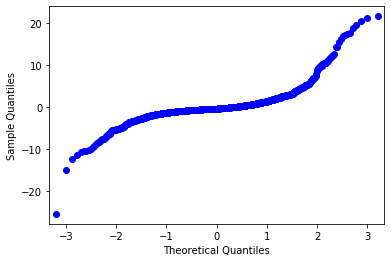

In [399]:
## lets check our qq plot to ensure normal distribution
sm.qqplot(model_deaths_sqrt_2.resid);

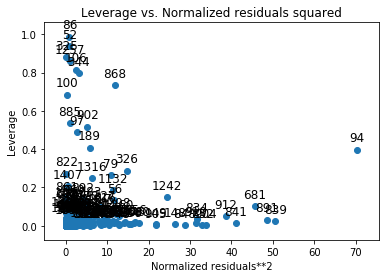

In [400]:
## actually worse than the log data from fitting a normal distribution perspective. Lets check for high leverage before throwing this out
sm.graphics.plot_leverage_resid2(model_deaths_sqrt_2, alpha=0.05);

In [410]:
## looks like we have some leverage
cleanedData_sqrt.iloc[[86,52,325,1257,106,344,868,100,885,902,97,94,189]]
##([86,52,325,1257,344,100,868,885,94,97])

,index,countyFIPS,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
86,204,6037,10105518,4981895,5123623,37.860876,7151444,906467,145254,1551894,37200,34.234486
52,103,4013,4410824,2181718,2229106,37.756130,3663379,275869,123814,202798,12814,12.124356
325,547,15003,980080,492574,487506,39.482318,212694,27758,3210,420967,94079,3.316625
1257,2623,48201,4698619,2333866,2364753,34.819834,3268948,933703,49922,348874,5865,10.677078
106,228,6085,1937570,980868,956702,37.955307,1028134,54961,23245,742295,8965,10.630146
344,610,17031,5180493,2516081,2664412,38.272575,3391043,1236170,38253,408151,3873,40.902323
868,1830,36005,1432132,674900,757232,36.284839,642607,624800,41726,64447,5940,58.796258
100,222,6073,3343364,1682449,1660915,37.678646,2522987,184779,44035,420909,19678,11.575837
885,1851,36047,2582830,1223764,1359066,37.220433,1278770,881296,23841,327010,2961,73.797019
902,1868,36081,2278906,1105389,1173517,39.653385,1092235,471907,30186,611274,5285,72.138755


In [411]:
cleanedData_sqrt_unlever = cleanedData_sqrt.drop([86,52,325,1257,106,344,868,100,885,902,97,94,189])

In [412]:
cleanedData_sqrt_unlever

,index,countyFIPS,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,WHITE,BLACK,NATIVE,ASIAN,ISLANDER,TotalDeaths
0,0,1001,55601,26995,28606,38.851406,42660,10915,267,681,62,1.732051
1,1,1003,218022,105657,112365,41.646504,190301,19492,1684,2508,146,2.000000
2,2,1005,24881,13133,11748,40.806720,12209,12042,164,113,46,1.000000
3,6,1013,19680,9165,10515,41.225610,10283,8839,74,259,10,1.000000
4,7,1015,114277,54914,59363,39.963807,86026,24153,617,1102,126,1.732051
...,...,...,...,...,...,...,...,...,...,...,...,...
1469,3117,55139,171020,86063,84957,39.332593,157410,3959,1276,5209,91,1.000000
1470,3125,56013,39531,19826,19705,39.149958,29180,238,8731,191,23,2.000000
1471,3128,56019,8460,4265,4195,43.346927,8053,65,143,60,1,1.000000
1472,3129,56021,98976,50170,48806,38.439187,90736,2711,1158,1352,133,1.000000


In [413]:
## running with the outliers removed actually made the model worse
model_deaths_sqrt_2_unlever = smf.ols(formula='TotalDeaths~(TOT_MALE*WHITE)+(TOT_FEMALE*WHITE)+(TOT_MALE*BLACK)+(TOT_FEMALE*BLACK)+(TOT_MALE*NATIVE)+(TOT_FEMALE*NATIVE)+(TOT_MALE*ASIAN)+(TOT_FEMALE*ASIAN)+(TOT_MALE*ISLANDER)+(TOT_MALE*ISLANDER)+(TOT_FEMALE*ISLANDER)', data=cleanedData_sqrt_unlever).fit()
model_deaths_sqrt_2_unlever.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalDeaths   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     128.4
Date:                Sun, 03 May 2020   Prob (F-statistic):          9.59e-274
Time:                        21:32:12   Log-Likelihood:                -3574.3
No. Observations:                1461   AIC:                             7185.
Df Residuals:                    1443   BIC:                             7280.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.3318      0.106     12.609      0.000       1.125       1.539
TOT_MALE               -0.0002   4.52e-05     -3.435      0.001      -0.000   -6.67e-05
WHITE                7.048e-05   3.62e-05      1.949      0.051   -4.56e-07       0.000
TOT_MALE:WHITE      -7.637e-11   7.09e-11     -1.077      0.282   -2.15e-10    6.27e-11
TOT_FEMALE           3.592e-05   5.24e-05      0.686      0.493   -6.68e-05       0.000
TOT_FEMALE:WHITE     7.549e-11   6.83e-11      1.106      0.269   -5.84e-11    2.09e-10
BLACK                7.821e-05   3.69e-05      2.118      0.034    5.79e-06       0.000
TOT_MALE:BLACK       4.366e-11   9.83e-11      0.444      0.657   -1.49e-10    2.36e-10
TOT_FEMALE:BLACK    -6.789e-11   9.33e-11     -0.728      0.467   -2.51e-10    1.15e-10
NATIVE               9.049e-05   4.38e-05      2.067      0.039     4.6e-06       0.000
TOT_MALE:NATIVE      -4.48e-09   2.36e-09     -1.896      0.058   -9.12e-09    1.56e-10
TOT_FEMALE:NATIVE    4.278e-09    2.3e-09      1.859      0.063   -2.36e-10    8.79e-09
ASIAN                   0.0001   3.85e-05      2.987      0.003    3.95e-05       0.000
TOT_MALE:ASIAN        -1.9e-09   2.54e-10     -7.490      0.000    -2.4e-09    -1.4e-09
TOT_FEMALE:ASIAN     1.849e-09   2.48e-10      7.461      0.000    1.36e-09    2.34e-09
ISLANDER               -0.0004      0.000     -2.617      0.009      -0.001      -0.000
TOT_MALE:ISLANDER     8.71e-08   8.03e-09     10.842      0.000    7.13e-08    1.03e-07
TOT_FEMALE:ISLANDER -8.609e-08   7.98e-09    -10.794      0.000   -1.02e-07   -7.04e-08
==============================================================================
Omnibus:                      801.408   Durbin-Watson:                   1.465
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16443.650
Skew:                           2.107   Prob(JB):                         0.00
Kurtosis:                      18.886   Cond. No.                     3.52e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.52e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

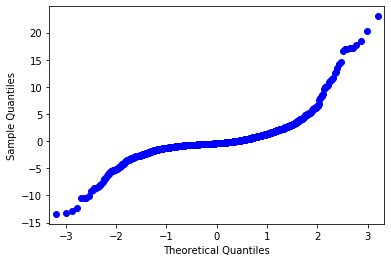

In [414]:
## qqplot didn't get more nomal with the unlevereged data
sm.qqplot(model_deaths_sqrt_2_unlever.resid);

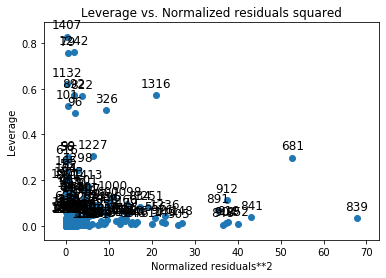

In [415]:
sm.graphics.plot_leverage_resid2(model_deaths_sqrt_2_unlever, alpha=0.05);

In [ ]:
## still a lot of outliers but don't want to continuously remove them
## of the sqrt models teh initial model was actually a better one but not sure this model is appropriate based on QQplot

Part 7: Conclusion

In conclusion, I have created a multilinear regression model that predicts the incidence of Covid-19 in a given county by demographic data. I have acheived an ok Rsquared value of .56 and noted that the coefficient on the black feature of the model suggested that this population is at higer risk to the disease.

I think the main reason I couldn't get a better result out of my model is that linear regressions don't deal with skewed data very well and mine was definately skewed left a bit. I think another issue was that the data set was colinear by nature as the features were all population measures and therefore colinear around the total population. While i did my best to deal with the colinearity I don't think it was escapeable in this context. 

One other issue that I was suprised by was that age had no statistically significant effect on the model. Considering the well known fact that COVID-19 is especially deadly to older populations i found this suprising. I think the issue may have been in my approach to computing average age. There were 15 5 year age ranges that i took the median of each for purposes of calculating average population. However the population over 85 was all in one bucket. At the time I made the assumption that coding this as 87 ( to keep the 2 year offset) was fine as the population above 85 was likely to be close to 85 and decrease exponetially anyways but perhaps this assumption artificially lowered the average age in high death counties to the point the model deemed average age to be statistically insignificant.

I think the model could be improved in several ways. 

First I think the data might better fit a poisson regression based on its counting nature and skew. That regression type was outside the scope of this class ( I couldn't find it in the book either) and when I attempted it I wasn't comfortable enough in my knowledge of how they work to interpret the results. Based on my research though this form of regression would be a more appropriate model for the data and likely have more predictive utitility.

Keeping in the linear realm I would like to add a couple additonal features now that the modeling is done. The first would be a population densisty metric. I think this would help some of the population colinearity issues as it would control for how spread out the population of a county is which might help the model cosidering the nature of the disease. I initially didnt include this because I thought that the population itself would have this information baked into the raw population value but after seeign the results I am reconsidering. I also would like to add some features around public health such as smoking rates, obesity, diabetes etc but I was unable to source a workable dataset at the county level for these items. I think it would help explain some of the variation by county and may even help explain some of the variation between demographic groups if one group had a higher incidence of a comorbidity than another. 
    
    